# Main Notebook

File to perform experiments

## Imports

In [1]:
import os
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
import tensorflow as tf

from models.GaussianProcess import GaussianProcess
from acquisition_functions.UseMO import usemo_acq
from acquisition_functions.MES import mes_acq, basic_mes_acq
from acquisition_functions.PESMO import pesmo_acq
from acquisition_functions.MESMO import mesmo_acq
from arguments.arguments import MainArguments

from MOObenchmark import MOOackley, MOOexponential, MOOquadratic_ackley, MOOnnHousesRegressionProb
from utils.calc_pareto import get_pareto_undominated_by, getSetfromFront

from models.MOOEvaluationProblem import MOOEvaluationProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.optimize import minimize

2023-06-12 23:09:53.501532: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 23:09:53.581680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 23:09:53.582750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 23:09:54.861203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Algorithm Arguments

In [2]:
d = 2 # input dimensions
    
seed = 1
np.random.seed(seed)

## iterations of the main algorithm
total_iter = 100
## iterations taken randomly at the beggining
initial_iter = 1

## bound of the inputs definition
### with the current implementations all the input dimensions must have the same bounds, 
### but this can be changed
lower_bound = 10
upper_bound = 1000

lowerBounds = [lower_bound]*d
upperBounds = [upper_bound]*d


## Evaluation

In [3]:
## Evaluation function definition
O = 2
C = 0

def evaluation(x):
    return MOOnnHousesRegressionProb(x)

This cell below gets the real pareto in two ways: with a grid and with a cheap optimizer (genetic algorithm) and plots both of them. These results are used in test problems as the actual pareto front. Although, to obtain these paretos many evaluations of the function are needed, so it has no sense running it in a costly black box problem.

In addition this is only prepared to plot a d=1, O=2 problem. We could visualize any problem, but the visualization get a lot more abstract and more plots are needed. If this is interesting I could do it.

Therefore I set the code below as text.

N = 1_001
X = np.linspace(lower_bound,upper_bound,N)
Z = np.zeros((N,2))

problem = MOOEvaluationProblem(evaluation, O=O, d=d, lowerBounds=lower_bound, upperBounds=upper_bound)
algorithm = NSGA2()
res = minimize( problem, 
                algorithm,
                termination = get_termination("n_gen",100))

real_pareto = res.F[np.argsort(res.F[:,0])]

for i in range(N):
    Z[i]=evaluation(X[i])

fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].plot(X, Z[:,0], 'b')
axs[0].plot(X, Z[:,1], 'k')
axs[0].plot(res.X, res.F[:,0], 'xr', markersize=5)
axs[0].plot(res.X, res.F[:,1], 'xr', markersize=5)

axs[1].plot(np.reshape(Z,(-1,2))[:,0], np.reshape(Z,(-1,2))[:,1], 'kx')
axs[1].plot(res.F[:,0], res.F[:,1], 'rx')
res
axs[2].plot(res.F[:,0], res.F[:,1], 'x')
plt.show()

In [4]:
def random_acq(GP: GaussianProcess, **kwargs):
    while True:
        x_rand = np.random.uniform(GP.lowerBounds, GP.upperBounds, GP.d)
        if GP.X is None or not x_rand in GP.X:
            break
    return x_rand, 0

## N experiments

C = [422.85178466 723.12124851]
C = [423, 723]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 112409944064.0000 - mae: 212239.5781 - mse: 112409698304.0000 - val_loss: 65933434880.0000 - val_mae: 176782.5000 - val_mse: 65933234176.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 61135081472.0000 - mae: 163197.9219 - mse: 61134950400.0000 - val_loss: 55411351552.0000 - val_mae: 155547.9375 - val_mse: 55411216384.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 58880970752.0000 - mae: 160869.9219 - mse: 58880798720.0000 - val_loss: 57033379840.0000 - val_mae: 161480.0469 - val_mse: 57033232384.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 57662607360.0000 - mae: 159490.7031 - mse: 57662464000.0000 - val_loss: 59570892800.0000 - val_mae: 154886.2344 - val_mse: 59570737152.0000
Epoch 5/6
517/517 [==============================] - 2s 4ms/step - loss: 56698478592.0000 - mae: 15

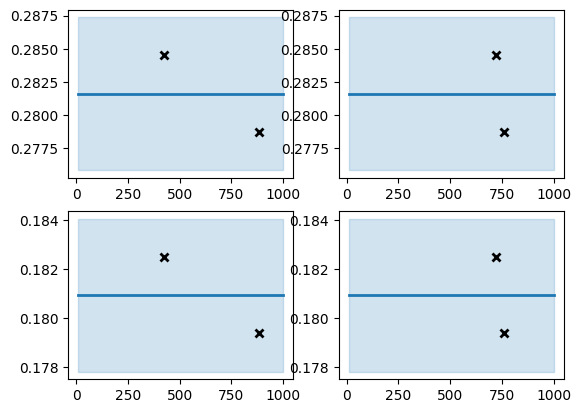

x_best =  [882.40252974 758.10290171]
acq_best =  [0.00011732 0.00048567]
C = [882.40252974 758.10290171]
C = [882, 758]
Epoch 1/6
517/517 [==============================] - 9s 15ms/step - loss: 102527614976.0000 - mae: 203467.6406 - mse: 102527418368.0000 - val_loss: 68456554496.0000 - val_mae: 166529.1406 - val_mse: 68456398848.0000
Epoch 2/6
517/517 [==============================] - 6s 12ms/step - loss: 60646060032.0000 - mae: 162626.6562 - mse: 60645896192.0000 - val_loss: 55212503040.0000 - val_mae: 160151.2188 - val_mse: 55212335104.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 59444981760.0000 - mae: 162785.7031 - mse: 59444817920.0000 - val_loss: 54637649920.0000 - val_mae: 156750.4062 - val_mse: 54637481984.0000
Epoch 4/6
517/517 [==============================] - 3s 7ms/step - loss: 57682128896.0000 - mae: 159560.3125 - mse: 57681981440.0000 - val_loss: 54327545856.0000 - val_mae: 160273.3750 - val_mse: 54327398400.0000
Epoch 5/6
517/517 [===

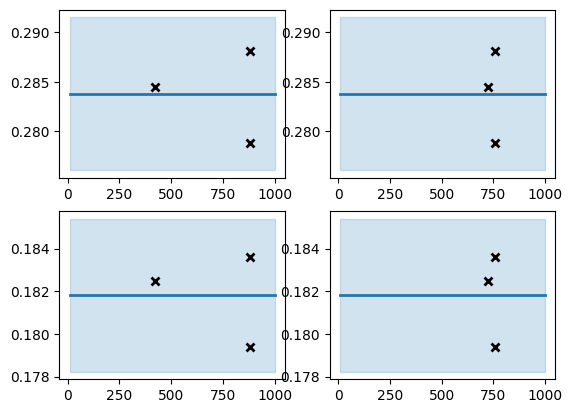

x_best =  [583.75289828 715.9820458 ]
acq_best =  [0.00154447 0.0007141 ]
C = [583.75289828 715.9820458 ]
C = [584, 716]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 109246267392.0000 - mae: 209468.5625 - mse: 109245964288.0000 - val_loss: 65317572608.0000 - val_mae: 168909.4375 - val_mse: 65317388288.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 60942143488.0000 - mae: 164063.7188 - mse: 60941967360.0000 - val_loss: 57403035648.0000 - val_mae: 153932.7812 - val_mse: 57402863616.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 58719203328.0000 - mae: 161482.2031 - mse: 58719051776.0000 - val_loss: 56757268480.0000 - val_mae: 153165.5312 - val_mse: 56757121024.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 57766858752.0000 - mae: 160090.2188 - mse: 57766682624.0000 - val_loss: 53510418432.0000 - val_mae: 154260.2031 - val_mse: 53510242304.0000
Epoch 5/6
517/517 [======

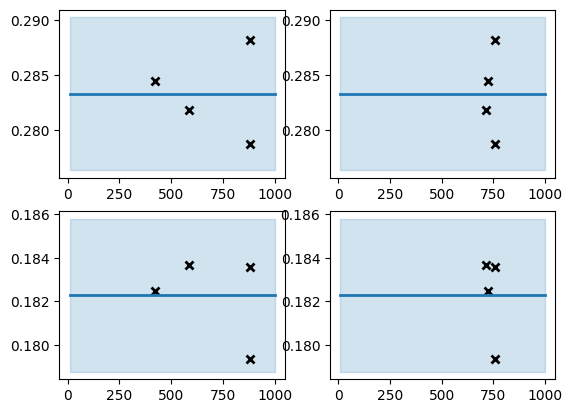

x_best =  [468.24381226 847.59974767]
acq_best =  [0.00137879 0.00069869]
C = [468.24381226 847.59974767]
C = [468, 848]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 112149102592.0000 - mae: 212055.0312 - mse: 112148922368.0000 - val_loss: 62629052416.0000 - val_mae: 160849.7188 - val_mse: 62628864000.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 63114149888.0000 - mae: 166181.5938 - mse: 63114014720.0000 - val_loss: 56447627264.0000 - val_mae: 156204.0781 - val_mse: 56447479808.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 59665666048.0000 - mae: 162962.6094 - mse: 59665453056.0000 - val_loss: 55543599104.0000 - val_mae: 153081.1406 - val_mse: 55543439360.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 57989148672.0000 - mae: 159285.5781 - mse: 57988968448.0000 - val_loss: 58615549952.0000 - val_mae: 153877.2031 - val_mse: 58615394304.0000
Epoch 5/6
517/517 [======

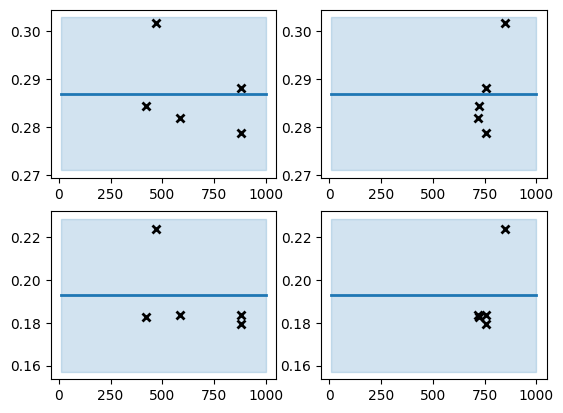

x_best =  [882.32457839 758.13473882]
acq_best =  [7.74760568e-04 1.17773675e-06]
C = [882.32457839 758.13473882]
C = [883, 758]
Epoch 1/6
517/517 [==============================] - 9s 15ms/step - loss: 101633122304.0000 - mae: 204180.8281 - mse: 101632983040.0000 - val_loss: 58428436480.0000 - val_mae: 157357.3594 - val_mse: 58428289024.0000
Epoch 2/6
517/517 [==============================] - 7s 13ms/step - loss: 59206356992.0000 - mae: 161338.7812 - mse: 59206180864.0000 - val_loss: 54180163584.0000 - val_mae: 157399.9688 - val_mse: 54179999744.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 59217981440.0000 - mae: 161923.5000 - mse: 59217870848.0000 - val_loss: 57113284608.0000 - val_mae: 167061.9375 - val_mse: 57113108480.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57581428736.0000 - mae: 159823.7031 - mse: 57581260800.0000 - val_loss: 55019429888.0000 - val_mae: 152230.1094 - val_mse: 55019282432.0000
Epoch 5/6
517/5

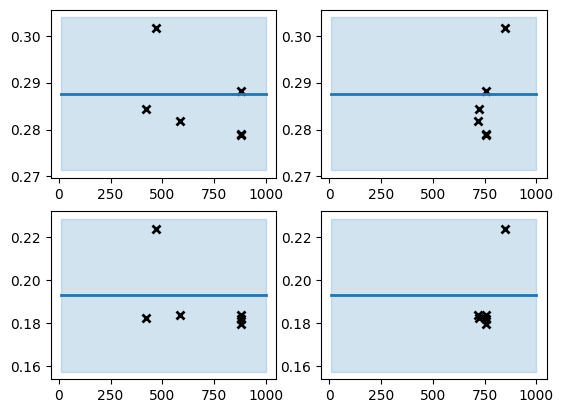

x_best =  [882.28171274 758.13091664]
acq_best =  [2.34105538e-07 1.40633833e-09]
C = [882.28171274 758.13091664]
C = [883, 758]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 99829293056.0000 - mae: 201047.9844 - mse: 99829063680.0000 - val_loss: 59507200000.0000 - val_mae: 156512.7344 - val_mse: 59507007488.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 59416031232.0000 - mae: 161623.0781 - mse: 59415875584.0000 - val_loss: 53027323904.0000 - val_mae: 152976.3906 - val_mse: 53027172352.0000
Epoch 3/6
517/517 [==============================] - 5s 9ms/step - loss: 57183531008.0000 - mae: 157779.1719 - mse: 57183379456.0000 - val_loss: 52934623232.0000 - val_mae: 152062.1406 - val_mse: 52934492160.0000
Epoch 4/6
517/517 [==============================] - 6s 12ms/step - loss: 56865206272.0000 - mae: 158290.6250 - mse: 56865009664.0000 - val_loss: 53733773312.0000 - val_mae: 153415.6719 - val_mse: 53733621760.0000
Epoch 5/6
517/517

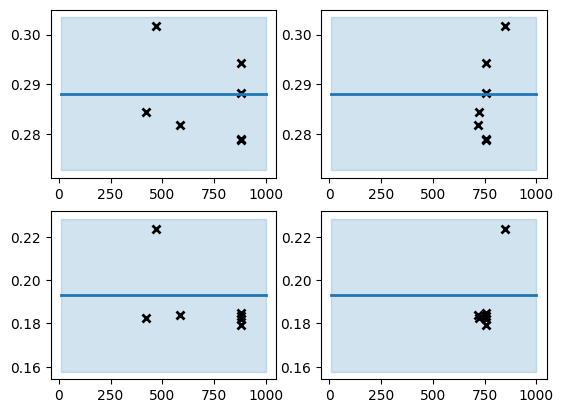

x_best =  [882.32324394 758.13804712]
acq_best =  [2.66900889e-09 1.08073869e-08]
C = [882.32324394 758.13804712]
C = [883, 758]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 423041236992.0000 - mae: 538371.3750 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 423041236992.0000 - mae: 538371.6875 - mse: 423040548864.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 423041269760.0000 - mae: 538371.6250 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 423041269760.0000 - mae: 538371.4375 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epo

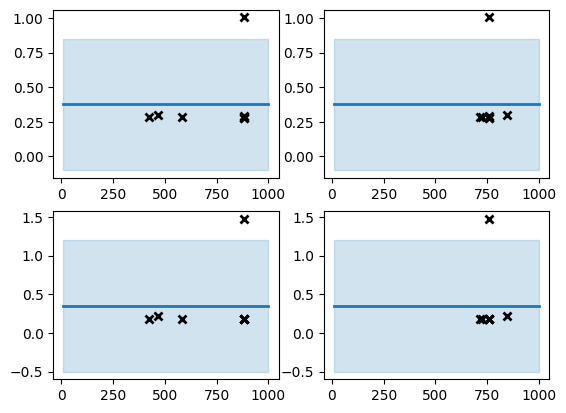

x_best =  [237.50433762 354.837576  ]
acq_best =  [0.09476462 0.16973556]
C = [237.50433762 354.837576  ]
C = [238, 355]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 127352872960.0000 - mae: 227914.2656 - mse: 127352659968.0000 - val_loss: 95836577792.0000 - val_mae: 212449.1406 - val_mse: 95836348416.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 68491276288.0000 - mae: 170200.4062 - mse: 68491128832.0000 - val_loss: 57537835008.0000 - val_mae: 159078.2812 - val_mse: 57537675264.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 60189831168.0000 - mae: 162460.9375 - mse: 60189671424.0000 - val_loss: 60031717376.0000 - val_mae: 161031.9531 - val_mse: 60031574016.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 58530250752.0000 - mae: 160531.6719 - mse: 58530095104.0000 - val_loss: 54363025408.0000 - val_mae: 159083.0312 - val_mse: 54362853376.0000
Epoch 5/6
517/517 [======

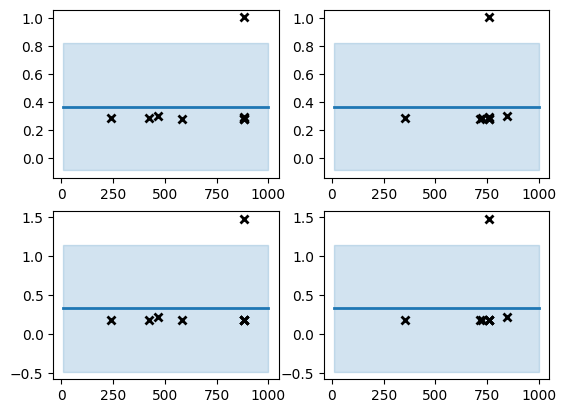

x_best =  [727.84510277 531.26490037]
acq_best =  [0.09007691 0.1612974 ]
C = [727.84510277 531.26490037]
C = [727, 531]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 108494151680.0000 - mae: 206826.3438 - mse: 108493832192.0000 - val_loss: 59972337664.0000 - val_mae: 157562.0000 - val_mse: 59972141056.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 61411106816.0000 - mae: 163516.7188 - mse: 61410959360.0000 - val_loss: 54853914624.0000 - val_mae: 153579.6562 - val_mse: 54853750784.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 57660809216.0000 - mae: 159417.0156 - mse: 57660661760.0000 - val_loss: 54677143552.0000 - val_mae: 156605.7812 - val_mse: 54676987904.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 57227452416.0000 - mae: 159040.2188 - mse: 57227288576.0000 - val_loss: 59189944320.0000 - val_mae: 170459.5625 - val_mse: 59189788672.0000
Epoch 5/6
517/517 [======

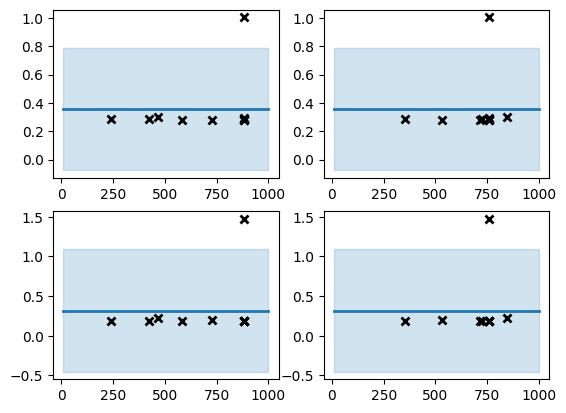

x_best =  [ 77.00293102 480.36392403]
acq_best =  [0.08609206 0.15390754]
C = [ 77.00293102 480.36392403]
C = [77, 481]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 135944101888.0000 - mae: 235553.3438 - mse: 135943872512.0000 - val_loss: 115461775360.0000 - val_mae: 209665.3125 - val_mse: 115461570560.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 85803376640.0000 - mae: 184838.9375 - mse: 85803212800.0000 - val_loss: 61200936960.0000 - val_mae: 161764.0312 - val_mse: 61200781312.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 61827477504.0000 - mae: 162950.0156 - mse: 61827321856.0000 - val_loss: 56363683840.0000 - val_mae: 155830.0000 - val_mse: 56363503616.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 58825625600.0000 - mae: 160523.6719 - mse: 58825416704.0000 - val_loss: 55847866368.0000 - val_mae: 157620.5469 - val_mse: 55847706624.0000
Epoch 5/6
517/517 [=====

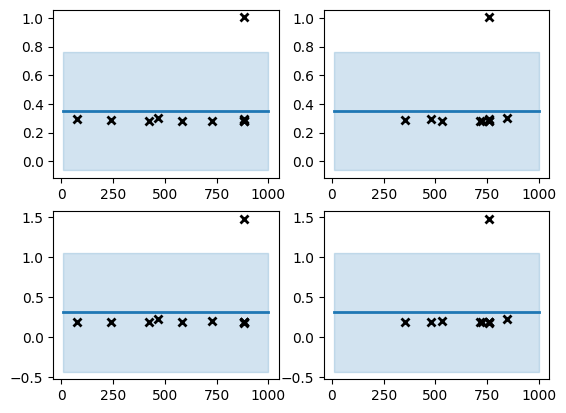

x_best =  [791.41773369 910.76259379]
acq_best =  [0.08241101 0.14751865]
C = [791.41773369 910.76259379]
C = [792, 911]
Epoch 1/6
517/517 [==============================] - 6s 9ms/step - loss: 101399576576.0000 - mae: 202942.5156 - mse: 101399388160.0000 - val_loss: 56843116544.0000 - val_mae: 157104.1562 - val_mse: 56842969088.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 60250312704.0000 - mae: 162898.5000 - mse: 60250144768.0000 - val_loss: 56629383168.0000 - val_mae: 160985.3281 - val_mse: 56629243904.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 59079376896.0000 - mae: 161934.0000 - mse: 59079168000.0000 - val_loss: 54459781120.0000 - val_mae: 151897.3438 - val_mse: 54459609088.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 56856600576.0000 - mae: 158902.4062 - mse: 56856412160.0000 - val_loss: 55135883264.0000 - val_mae: 155281.9375 - val_mse: 55135715328.0000
Epoch 5/6
517/517 [======

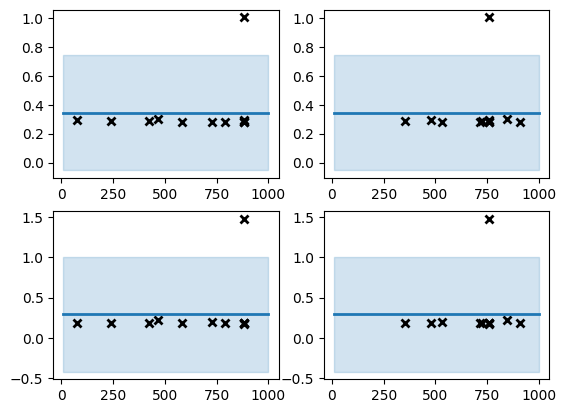

x_best =  [807.53568593 411.26462997]
acq_best =  [0.07929438 0.14189128]
C = [807.53568593 411.26462997]
C = [808, 411]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 108921683968.0000 - mae: 206315.1094 - mse: 108921454592.0000 - val_loss: 60621361152.0000 - val_mae: 162773.9844 - val_mse: 60621234176.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 61336137728.0000 - mae: 163096.8281 - mse: 61335945216.0000 - val_loss: 54380486656.0000 - val_mae: 154597.2500 - val_mse: 54380343296.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 59237916672.0000 - mae: 161334.7812 - mse: 59237761024.0000 - val_loss: 53116227584.0000 - val_mae: 155008.7500 - val_mse: 53116071936.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 58177499136.0000 - mae: 160037.2188 - mse: 58177355776.0000 - val_loss: 62224371712.0000 - val_mae: 175667.1875 - val_mse: 62224183296.0000
Epoch 5/6
517/517 [======

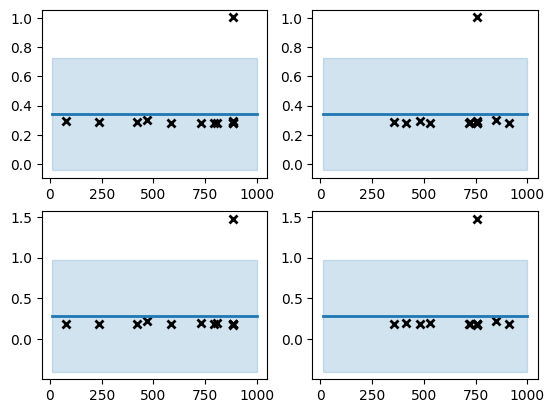

x_best =  [125.37282244 446.16200916]
acq_best =  [0.07648046 0.1367296 ]
C = [125.37282244 446.16200916]
C = [125, 446]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 130155003904.0000 - mae: 229451.0781 - mse: 130154733568.0000 - val_loss: 103801257984.0000 - val_mae: 192851.6562 - val_mse: 103801085952.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 73786040320.0000 - mae: 173506.8438 - mse: 73785851904.0000 - val_loss: 60726218752.0000 - val_mae: 171676.9688 - val_mse: 60726018048.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 60747083776.0000 - mae: 163432.6250 - mse: 60746932224.0000 - val_loss: 61124648960.0000 - val_mae: 169616.8438 - val_mse: 61124472832.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 58999377920.0000 - mae: 161977.6562 - mse: 58999209984.0000 - val_loss: 55017463808.0000 - val_mae: 156965.8594 - val_mse: 55017328640.0000
Epoch 5/6
517/517 [====

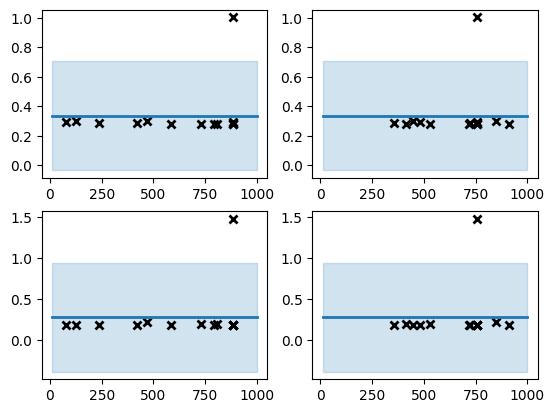

x_best =  [832.63111863 626.02102346]
acq_best =  [0.073813   0.13213827]
C = [832.63111863 626.02102346]
C = [833, 626]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 104806211584.0000 - mae: 205834.0156 - mse: 104806014976.0000 - val_loss: 59890962432.0000 - val_mae: 167794.7500 - val_mse: 59890810880.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 60830478336.0000 - mae: 164270.5469 - mse: 60830306304.0000 - val_loss: 58574028800.0000 - val_mae: 155249.3750 - val_mse: 58573860864.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 58677485568.0000 - mae: 161032.8438 - mse: 58677342208.0000 - val_loss: 54442622976.0000 - val_mae: 158435.4375 - val_mse: 54442475520.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 57652547584.0000 - mae: 158975.0781 - mse: 57652338688.0000 - val_loss: 57195491328.0000 - val_mae: 156029.0469 - val_mse: 57195335680.0000
Epoch 5/6
517/517 [======

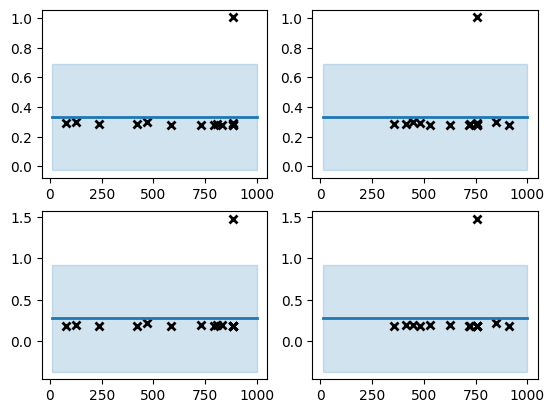

x_best =  [137.92369217 614.87849028]
acq_best =  [0.07156006 0.12797579]
C = [137.92369217 614.87849028]
C = [138, 615]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 132528865280.0000 - mae: 232102.0000 - mse: 132528553984.0000 - val_loss: 109631365120.0000 - val_mae: 215280.8438 - val_mse: 109631160320.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 79997886464.0000 - mae: 178424.7969 - mse: 79997706240.0000 - val_loss: 58735099904.0000 - val_mae: 155559.5469 - val_mse: 58734952448.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 60832464896.0000 - mae: 161750.9531 - mse: 60832284672.0000 - val_loss: 56181166080.0000 - val_mae: 158212.8906 - val_mse: 56181010432.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 58498977792.0000 - mae: 160385.0000 - mse: 58498797568.0000 - val_loss: 53283033088.0000 - val_mae: 152078.2812 - val_mse: 53282897920.0000
Epoch 5/6
517/517 [====

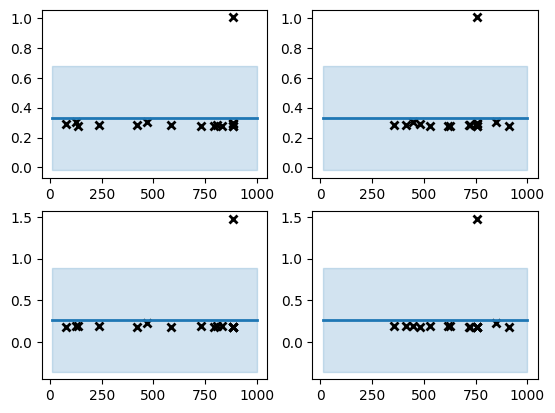

x_best =  [207.50069467  18.54584315]
acq_best =  [0.0694818 0.1241851]
C = [207.50069467  18.54584315]
C = [208, 19]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 153065684992.0000 - mae: 251057.1406 - mse: 153065455616.0000 - val_loss: 121829130240.0000 - val_mae: 213137.5469 - val_mse: 121828941824.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 104624095232.0000 - mae: 203062.0000 - mse: 104623857664.0000 - val_loss: 79378685952.0000 - val_mae: 176627.9688 - val_mse: 79378481152.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 69244706816.0000 - mae: 168100.0000 - mse: 69244559360.0000 - val_loss: 59602911232.0000 - val_mae: 160710.3281 - val_mse: 59602751488.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 63029530624.0000 - mae: 164469.4531 - mse: 63029379072.0000 - val_loss: 58899591168.0000 - val_mae: 162987.0000 - val_mse: 58899439616.0000
Epoch 5/6
517/517 [=====

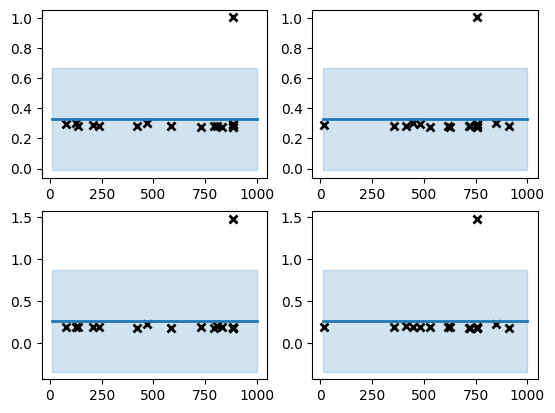

x_best =  [523.49685563 406.58633988]
acq_best =  [0.06751686 0.12068772]
C = [523.49685563 406.58633988]
C = [523, 406]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 109971308544.0000 - mae: 211954.7188 - mse: 109971128320.0000 - val_loss: 62048399360.0000 - val_mae: 163415.4062 - val_mse: 62048215040.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 61664591872.0000 - mae: 164085.2188 - mse: 61664407552.0000 - val_loss: 58099019776.0000 - val_mae: 154620.1875 - val_mse: 58098888704.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 59068977152.0000 - mae: 161860.8594 - mse: 59068788736.0000 - val_loss: 56545374208.0000 - val_mae: 164958.4531 - val_mse: 56545218560.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57486188544.0000 - mae: 159878.7188 - mse: 57486000128.0000 - val_loss: 57270112256.0000 - val_mae: 153786.0156 - val_mse: 57269940224.0000
Epoch 5/6
517/517 [======

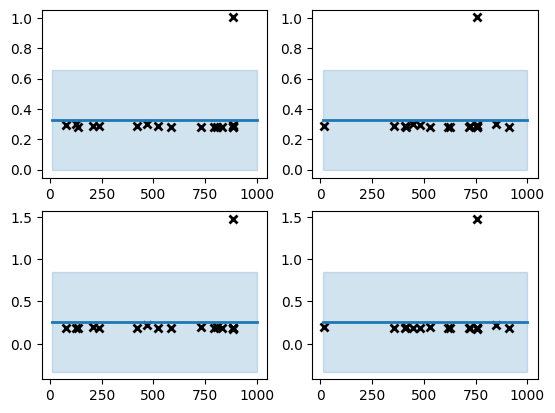

x_best =  [548.62907984 357.68880984]
acq_best =  [0.06572903 0.11749867]
C = [548.62907984 357.68880984]
C = [549, 357]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 115631898624.0000 - mae: 215916.5625 - mse: 115631702016.0000 - val_loss: 69819047936.0000 - val_mae: 162555.7969 - val_mse: 69818900480.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 62266417152.0000 - mae: 164680.2344 - mse: 62266245120.0000 - val_loss: 56666558464.0000 - val_mae: 165896.7031 - val_mse: 56666402816.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 58694062080.0000 - mae: 161241.2969 - mse: 58693902336.0000 - val_loss: 58232180736.0000 - val_mae: 168146.7188 - val_mse: 58231992320.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 57924714496.0000 - mae: 160300.2812 - mse: 57924546560.0000 - val_loss: 55623766016.0000 - val_mae: 154170.9688 - val_mse: 55623618560.0000
Epoch 5/6
517/517 [======

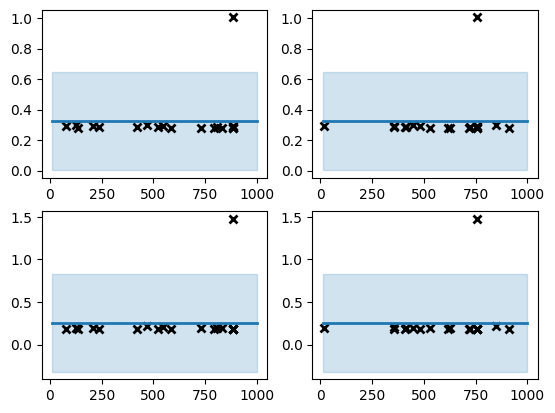

x_best =  [264.72027687 294.44478766]
acq_best =  [0.06405482 0.11448214]
C = [264.72027687 294.44478766]
C = [264, 295]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 127912501248.0000 - mae: 226945.8125 - mse: 127912263680.0000 - val_loss: 89814106112.0000 - val_mae: 186794.6875 - val_mse: 89813966848.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 68263956480.0000 - mae: 168488.9375 - mse: 68263755776.0000 - val_loss: 61254127616.0000 - val_mae: 173863.4062 - val_mse: 61253971968.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 59545571328.0000 - mae: 162126.7344 - mse: 59545403392.0000 - val_loss: 57767190528.0000 - val_mae: 155002.3906 - val_mse: 57767059456.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 57710628864.0000 - mae: 159811.0781 - mse: 57710473216.0000 - val_loss: 53763215360.0000 - val_mae: 153276.8906 - val_mse: 53763059712.0000
Epoch 5/6
517/517 [======

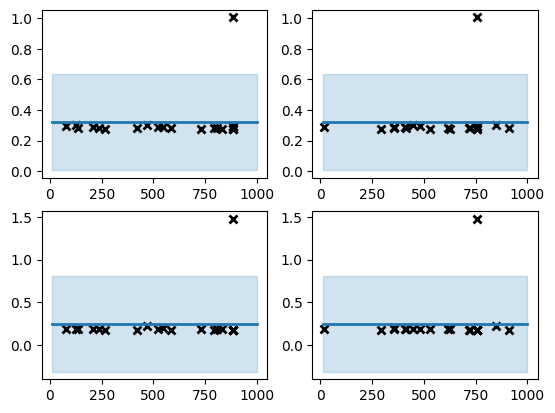

x_best =  [779.40254482 249.23772042]
acq_best =  [0.06256707 0.11176261]
C = [779.40254482 249.23772042]
C = [779, 249]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 121284935680.0000 - mae: 221244.8438 - mse: 121284730880.0000 - val_loss: 71634837504.0000 - val_mae: 166777.6875 - val_mse: 71634665472.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 62482296832.0000 - mae: 164485.2812 - mse: 62482132992.0000 - val_loss: 58537496576.0000 - val_mae: 169059.5156 - val_mse: 58537320448.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 58334920704.0000 - mae: 159619.7656 - mse: 58334760960.0000 - val_loss: 55892713472.0000 - val_mae: 154607.4375 - val_mse: 55892557824.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57539383296.0000 - mae: 159045.1406 - mse: 57539203072.0000 - val_loss: 64769736704.0000 - val_mae: 159832.4062 - val_mse: 64769576960.0000
Epoch 5/6
517/517 [======

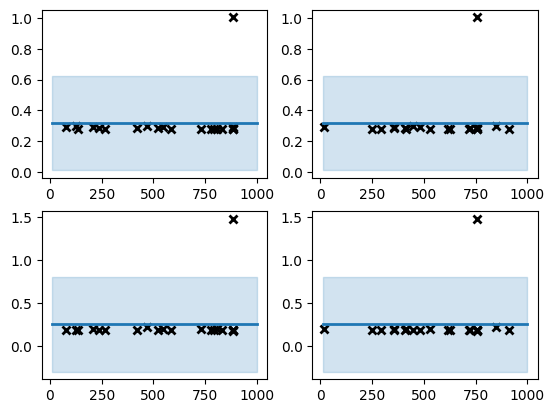

x_best =  [948.32011769 772.29159333]
acq_best =  [0.0611631  0.10921074]
C = [948.32011769 772.29159333]
C = [948, 773]
Epoch 1/6
517/517 [==============================] - 4s 7ms/step - loss: 100317241344.0000 - mae: 201068.1875 - mse: 100317028352.0000 - val_loss: 57000820736.0000 - val_mae: 156479.2969 - val_mse: 57000673280.0000
Epoch 2/6
517/517 [==============================] - 4s 9ms/step - loss: 59499888640.0000 - mae: 162213.5469 - mse: 59499732992.0000 - val_loss: 55465660416.0000 - val_mae: 153801.3438 - val_mse: 55465504768.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 58466443264.0000 - mae: 161383.6562 - mse: 58466287616.0000 - val_loss: 53666635776.0000 - val_mae: 156510.4375 - val_mse: 53666471936.0000
Epoch 4/6
517/517 [==============================] - 5s 10ms/step - loss: 57600425984.0000 - mae: 159431.3125 - mse: 57600266240.0000 - val_loss: 57345847296.0000 - val_mae: 168028.7812 - val_mse: 57345679360.0000
Epoch 5/6
517/517 [====

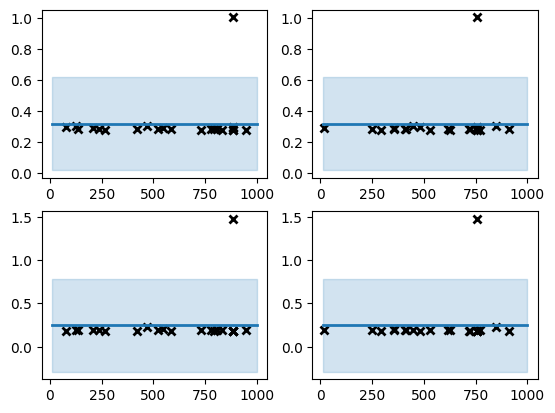

x_best =  [ 14.41792466 799.88060796]
acq_best =  [0.0598583  0.10682821]
C = [ 14.41792466 799.88060796]
C = [14, 800]
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 423041269760.0000 - mae: 538371.3125 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 423041302528.0000 - mae: 538371.1875 - mse: 423040811008.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 423041236992.0000 - mae: 538371.5625 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 423041171456.0000 - mae: 538371.4375 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
51

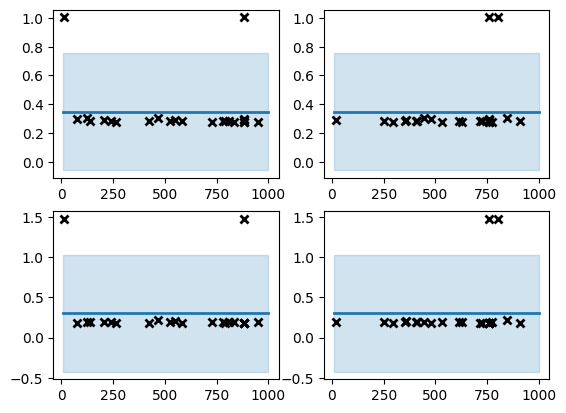

x_best =  [274.99522092 347.12388854]
acq_best =  [0.08092836 0.14447094]
C = [274.99522092 347.12388854]
C = [275, 347]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 423041368064.0000 - mae: 538371.3750 - mse: 423040876544.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 423041236992.0000 - mae: 538371.5625 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 423040974848.0000 - mae: 538371.8125 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 423041171456.0000 - mae: 538371.6875 - mse: 423040548864.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

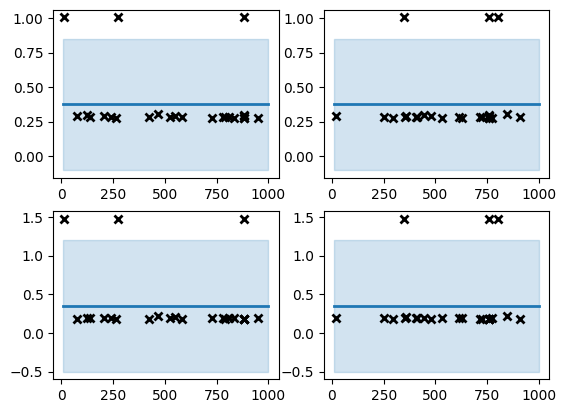

x_best =  [831.90919909 132.96924844]
acq_best =  [0.09496971 0.16954842]
C = [831.90919909 132.96924844]
C = [832, 133]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 121310330880.0000 - mae: 220222.6406 - mse: 121310068736.0000 - val_loss: 77242417152.0000 - val_mae: 175277.5312 - val_mse: 77242245120.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 63579303936.0000 - mae: 164502.3125 - mse: 63579123712.0000 - val_loss: 54218620928.0000 - val_mae: 155684.6875 - val_mse: 54218452992.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 59197440000.0000 - mae: 161305.0781 - mse: 59197284352.0000 - val_loss: 84232749056.0000 - val_mae: 180968.7344 - val_mse: 84232544256.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 58191355904.0000 - mae: 159747.7969 - mse: 58191167488.0000 - val_loss: 55405129728.0000 - val_mae: 153124.5000 - val_mse: 55404961792.0000
Epoch 5/6
517/517 [======

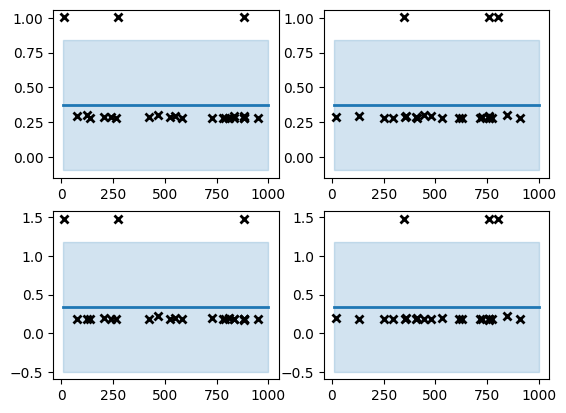

x_best =  [537.68109902 980.33431818]
acq_best =  [0.09327933 0.16662108]
C = [537.68109902 980.33431818]
C = [538, 981]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 106640490496.0000 - mae: 205395.4531 - mse: 106640326656.0000 - val_loss: 60419796992.0000 - val_mae: 158182.7812 - val_mse: 60419624960.0000
Epoch 2/6
517/517 [==============================] - 5s 9ms/step - loss: 62083899392.0000 - mae: 164602.4375 - mse: 62083760128.0000 - val_loss: 54060994560.0000 - val_mae: 155046.9688 - val_mse: 54060851200.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 58778525696.0000 - mae: 160360.7969 - mse: 58778386432.0000 - val_loss: 57403588608.0000 - val_mae: 156035.5625 - val_mse: 57403441152.0000
Epoch 4/6
517/517 [==============================] - 5s 10ms/step - loss: 59055583232.0000 - mae: 160612.1250 - mse: 59055415296.0000 - val_loss: 54192582656.0000 - val_mae: 160710.7188 - val_mse: 54192439296.0000
Epoch 5/6
517/517 [====

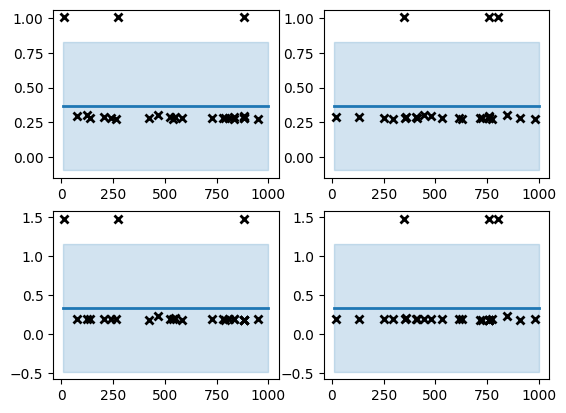

x_best =  [317.2879049   56.98736036]
acq_best =  [0.09175664 0.1638257 ]
C = [317.2879049   56.98736036]
C = [318, 57]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 423040974848.0000 - mae: 538371.6250 - mse: 423040516096.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 423041335296.0000 - mae: 538371.6875 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 423041368064.0000 - mae: 538371.5000 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 423041335296.0000 - mae: 538371.4375 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
51

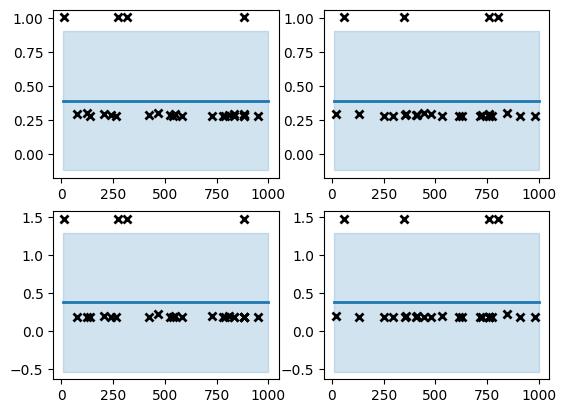

x_best =  [967.1947878  837.91374214]
acq_best =  [0.10201381 0.18210574]
C = [967.1947878  837.91374214]
C = [967, 838]
Epoch 1/6
517/517 [==============================] - 6s 9ms/step - loss: 423041204224.0000 - mae: 538371.6250 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 423041433600.0000 - mae: 538371.6875 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 423041236992.0000 - mae: 538371.6250 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 423041171456.0000 - mae: 538371.5000 - mse: 423040516096.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

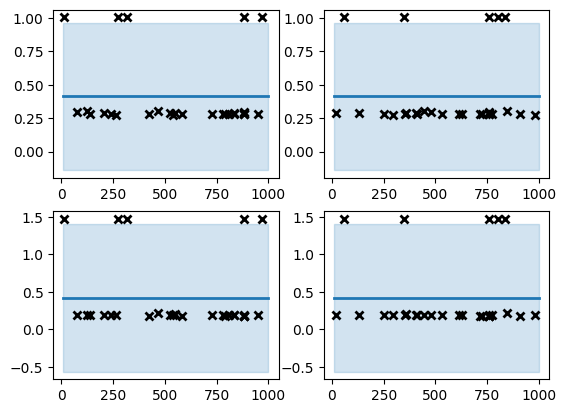

x_best =  [975.54602604 173.21861942]
acq_best =  [0.10997901 0.1963377 ]
C = [975.54602604 173.21861942]
C = [976, 173]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 108302311424.0000 - mae: 208920.2188 - mse: 108302082048.0000 - val_loss: 59857874944.0000 - val_mae: 163843.4219 - val_mse: 59857719296.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 61924589568.0000 - mae: 164852.8906 - mse: 61924425728.0000 - val_loss: 55283920896.0000 - val_mae: 156647.9688 - val_mse: 55283765248.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 58040819712.0000 - mae: 159559.8594 - mse: 58040635392.0000 - val_loss: 52869079040.0000 - val_mae: 152970.4531 - val_mse: 52868927488.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57216507904.0000 - mae: 158705.8750 - mse: 57216339968.0000 - val_loss: 52937220096.0000 - val_mae: 154374.3594 - val_mse: 52937076736.0000
Epoch 5/6
517/517 [======

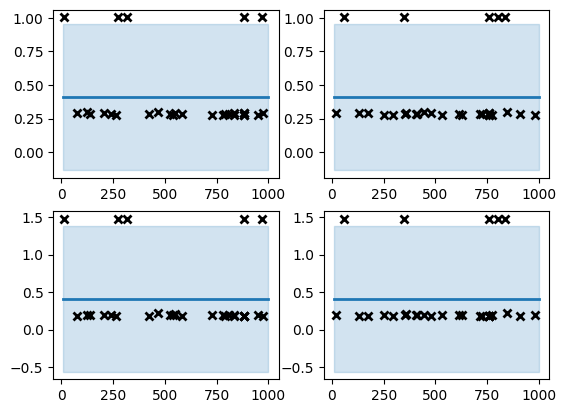

x_best =  [927.14873321 954.19909908]
acq_best =  [0.10841881 0.19372189]
C = [927.14873321 954.19909908]
C = [927, 954]
Epoch 1/6
517/517 [==============================] - 5s 9ms/step - loss: 99571892224.0000 - mae: 200182.6562 - mse: 99571654656.0000 - val_loss: 56835477504.0000 - val_mae: 154784.8750 - val_mse: 56835309568.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 60106944512.0000 - mae: 163073.6250 - mse: 60106797056.0000 - val_loss: 54641213440.0000 - val_mae: 153416.5469 - val_mse: 54641070080.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 59497263104.0000 - mae: 162123.6250 - mse: 59497082880.0000 - val_loss: 68008067072.0000 - val_mae: 164597.7188 - val_mse: 68007899136.0000
Epoch 4/6
517/517 [==============================] - 6s 11ms/step - loss: 57739350016.0000 - mae: 159648.1250 - mse: 57739169792.0000 - val_loss: 54505086976.0000 - val_mae: 153647.0000 - val_mse: 54504955904.0000
Epoch 5/6
517/517 [=====

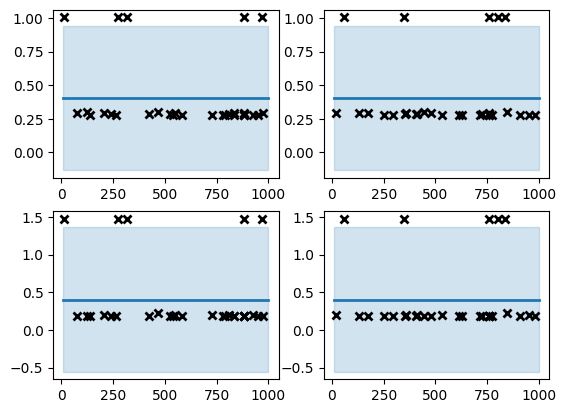

x_best =  [776.07348857 512.0164142 ]
acq_best =  [0.10700616 0.19111091]
C = [776.07348857 512.0164142 ]
C = [776, 512]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 106237263872.0000 - mae: 207535.2031 - mse: 106237018112.0000 - val_loss: 78319099904.0000 - val_mae: 182390.3125 - val_mse: 78318927872.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 60399329280.0000 - mae: 163180.8125 - mse: 60399194112.0000 - val_loss: 54115635200.0000 - val_mae: 153309.6250 - val_mse: 54115475456.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 58773057536.0000 - mae: 161571.4688 - mse: 58772910080.0000 - val_loss: 55969550336.0000 - val_mae: 163543.7500 - val_mse: 55969394688.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 58326175744.0000 - mae: 161241.9688 - mse: 58325999616.0000 - val_loss: 56134328320.0000 - val_mae: 152412.5312 - val_mse: 56134189056.0000
Epoch 5/6
517/517 [======

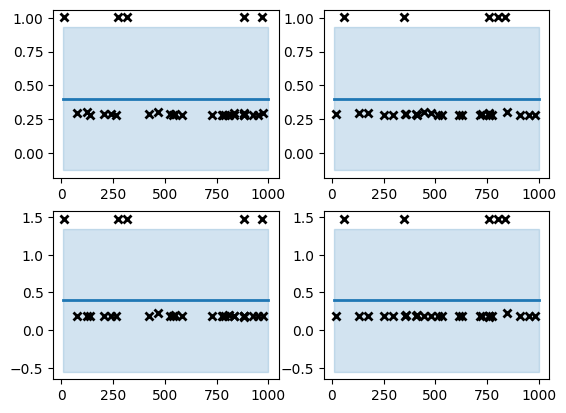

x_best =  [197.48302363 280.70487927]
acq_best =  [0.10563481 0.18861116]
C = [197.48302363 280.70487927]
C = [198, 281]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 134190956544.0000 - mae: 233064.7188 - mse: 134190710784.0000 - val_loss: 96317743104.0000 - val_mae: 188010.1094 - val_mse: 96317530112.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 72271314944.0000 - mae: 173882.1562 - mse: 72271134720.0000 - val_loss: 59261300736.0000 - val_mae: 160345.4375 - val_mse: 59261104128.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 62323666944.0000 - mae: 165469.9375 - mse: 62323527680.0000 - val_loss: 59107684352.0000 - val_mae: 166524.9844 - val_mse: 59107504128.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 60519407616.0000 - mae: 163443.4219 - mse: 60519235584.0000 - val_loss: 56972161024.0000 - val_mae: 156209.8906 - val_mse: 56971976704.0000
Epoch 5/6
517/517 [======

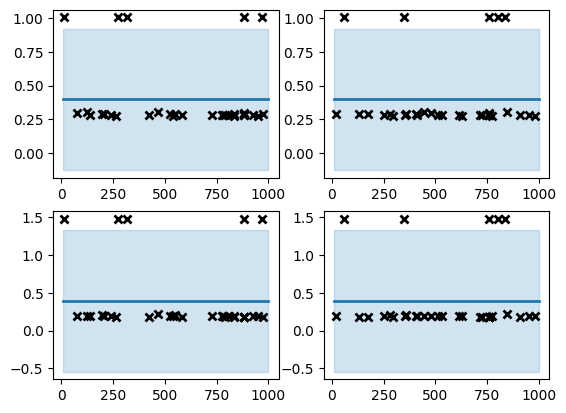

x_best =  [266.62101587 222.29700824]
acq_best =  [0.10426749 0.18613514]
C = [266.62101587 222.29700824]
C = [267, 222]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 128050061312.0000 - mae: 228222.4688 - mse: 128049864704.0000 - val_loss: 95639240704.0000 - val_mae: 212904.9531 - val_mse: 95639044096.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 68868268032.0000 - mae: 169062.1719 - mse: 68868087808.0000 - val_loss: 55927308288.0000 - val_mae: 156888.3594 - val_mse: 55927152640.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 59051282432.0000 - mae: 160916.0469 - mse: 59051118592.0000 - val_loss: 56659787776.0000 - val_mae: 165419.3125 - val_mse: 56659623936.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 57936314368.0000 - mae: 160010.7969 - mse: 57936154624.0000 - val_loss: 57982660608.0000 - val_mae: 156112.7188 - val_mse: 57982504960.0000
Epoch 5/6
517/517 [======

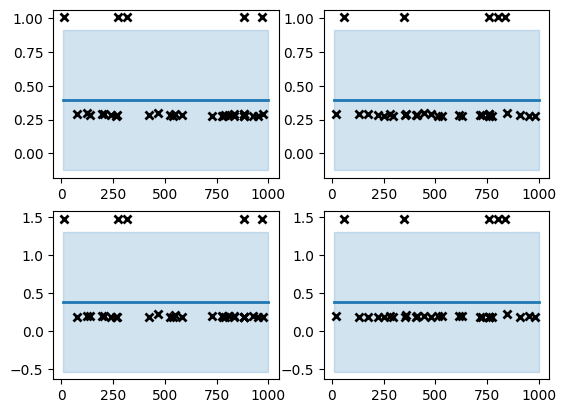

x_best =  [946.08058875 873.76891351]
acq_best =  [0.10298072 0.18385156]
C = [946.08058875 873.76891351]
C = [946, 873]
Epoch 1/6
517/517 [==============================] - 8s 13ms/step - loss: 101637480448.0000 - mae: 201247.1562 - mse: 101637300224.0000 - val_loss: 62932643840.0000 - val_mae: 161155.7500 - val_mse: 62932471808.0000
Epoch 2/6
517/517 [==============================] - 8s 15ms/step - loss: 61747286016.0000 - mae: 164165.2031 - mse: 61747118080.0000 - val_loss: 53971845120.0000 - val_mae: 152064.3594 - val_mse: 53971709952.0000
Epoch 3/6
517/517 [==============================] - 8s 16ms/step - loss: 58563846144.0000 - mae: 159888.5938 - mse: 58563690496.0000 - val_loss: 52633657344.0000 - val_mae: 151388.2031 - val_mse: 52633497600.0000
Epoch 4/6
517/517 [==============================] - 7s 13ms/step - loss: 57066344448.0000 - mae: 158503.7812 - mse: 57066192896.0000 - val_loss: 53390159872.0000 - val_mae: 153734.6406 - val_mse: 53389987840.0000
Epoch 5/6
517/517 [==

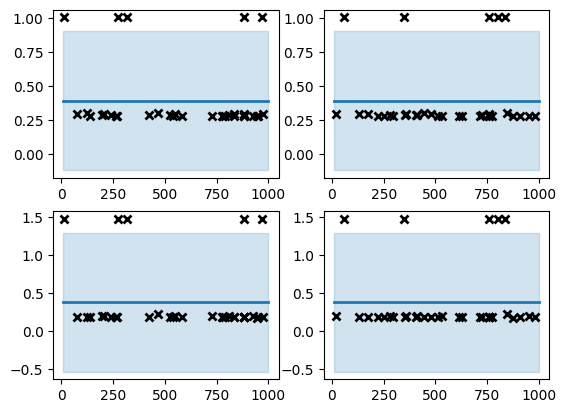

x_best =  [816.02558109 948.03462141]
acq_best =  [0.10176176 0.18163222]
C = [816.02558109 948.03462141]
C = [816, 948]
Epoch 1/6
517/517 [==============================] - 7s 12ms/step - loss: 110148435968.0000 - mae: 211324.9844 - mse: 110148296704.0000 - val_loss: 57366077440.0000 - val_mae: 161975.4531 - val_mse: 57365929984.0000
Epoch 2/6
517/517 [==============================] - 6s 12ms/step - loss: 60632875008.0000 - mae: 163294.3125 - mse: 60632727552.0000 - val_loss: 56812056576.0000 - val_mae: 163068.3438 - val_mse: 56811880448.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 58029973504.0000 - mae: 160584.2344 - mse: 58029797376.0000 - val_loss: 66676924416.0000 - val_mae: 170973.9844 - val_mse: 66676731904.0000
Epoch 4/6
517/517 [==============================] - 6s 11ms/step - loss: 56631017472.0000 - mae: 158193.2656 - mse: 56630870016.0000 - val_loss: 54238449664.0000 - val_mae: 160084.9062 - val_mse: 54238294016.0000
Epoch 5/6
517/517 [==

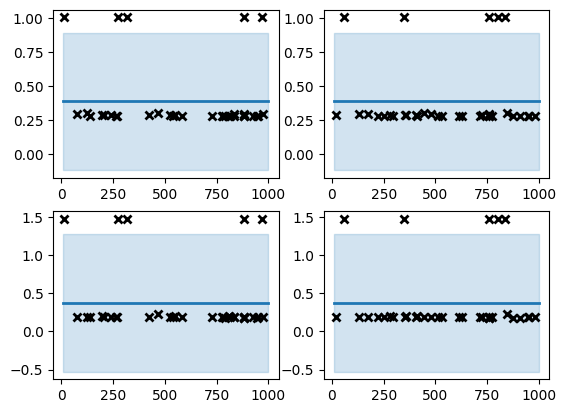

x_best =  [259.15096816 376.08427246]
acq_best =  [0.10057284 0.17946154]
C = [259.15096816 376.08427246]
C = [259, 376]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 126678376448.0000 - mae: 226431.9844 - mse: 126678171648.0000 - val_loss: 93462732800.0000 - val_mae: 188458.6406 - val_mse: 93462519808.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 68564250624.0000 - mae: 168543.1562 - mse: 68564094976.0000 - val_loss: 58526089216.0000 - val_mae: 155992.6094 - val_mse: 58525937664.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 58444165120.0000 - mae: 159577.8594 - mse: 58443988992.0000 - val_loss: 57589989376.0000 - val_mae: 169143.3750 - val_mse: 57589846016.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 57415331840.0000 - mae: 158266.8281 - mse: 57415168000.0000 - val_loss: 54577213440.0000 - val_mae: 157662.4531 - val_mse: 54577057792.0000
Epoch 5/6
517/517 [======

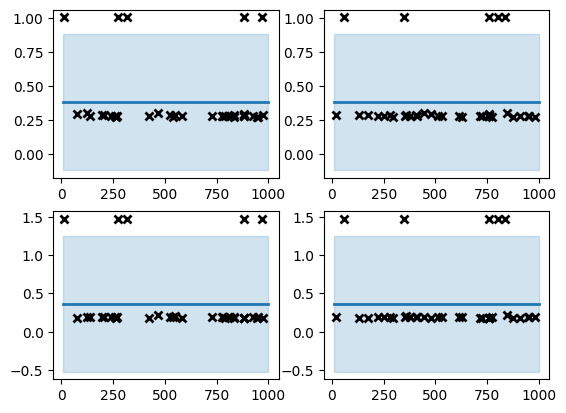

x_best =  [337.56934669  44.86074493]
acq_best =  [0.09942248 0.17734152]
C = [337.56934669  44.86074493]
C = [337, 44]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 134777552896.0000 - mae: 234496.0938 - mse: 134777298944.0000 - val_loss: 104571797504.0000 - val_mae: 201059.3281 - val_mse: 104571568128.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 77952032768.0000 - mae: 176849.9688 - mse: 77951836160.0000 - val_loss: 58987237376.0000 - val_mae: 159496.1875 - val_mse: 58987065344.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 60699013120.0000 - mae: 161729.5156 - mse: 60698836992.0000 - val_loss: 55197487104.0000 - val_mae: 154935.7031 - val_mse: 55197335552.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 58101276672.0000 - mae: 158827.7812 - mse: 58101108736.0000 - val_loss: 58172252160.0000 - val_mae: 152801.7031 - val_mse: 58172100608.0000
Epoch 5/6
517/517 [=====

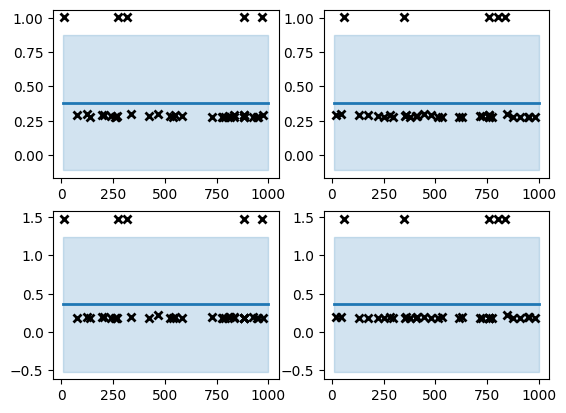

x_best =  [866.63965367 510.73325156]
acq_best =  [0.09821589 0.17526506]
C = [866.63965367 510.73325156]
C = [867, 511]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 423041236992.0000 - mae: 538371.3750 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 423041040384.0000 - mae: 538371.5625 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 423041040384.0000 - mae: 538371.5000 - mse: 423040483328.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 423041073152.0000 - mae: 538371.2500 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

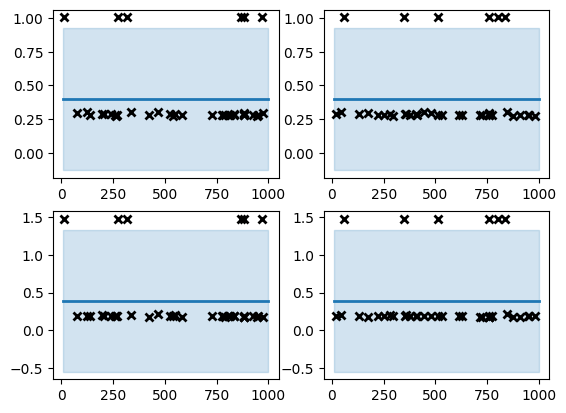

x_best =  [635.77269185 631.44241115]
acq_best =  [0.10475303 0.18688111]
C = [635.77269185 631.44241115]
C = [635, 632]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 135211311104.0000 - mae: 236579.7344 - mse: 135211089920.0000 - val_loss: 66147250176.0000 - val_mae: 160530.8750 - val_mse: 66147069952.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 61456297984.0000 - mae: 163491.0156 - mse: 61456121856.0000 - val_loss: 54401359872.0000 - val_mae: 153932.3438 - val_mse: 54401187840.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 58482364416.0000 - mae: 160331.4844 - mse: 58482221056.0000 - val_loss: 62142312448.0000 - val_mae: 182451.0781 - val_mse: 62142152704.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 57371840512.0000 - mae: 158948.7031 - mse: 57371656192.0000 - val_loss: 56857432064.0000 - val_mae: 162116.6406 - val_mse: 56857272320.0000
Epoch 5/6
517/517 [======

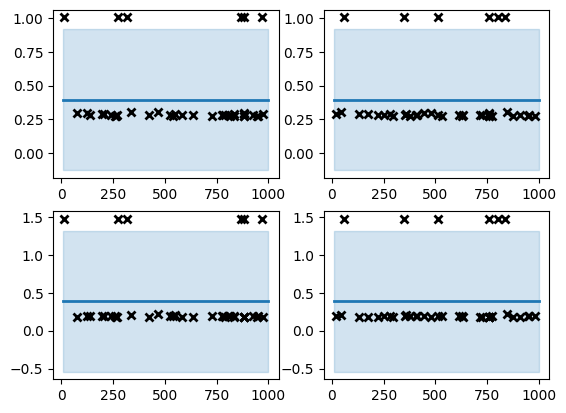

x_best =  [755.19689676 314.41365117]
acq_best =  [0.10365852 0.18499477]
C = [755.19689676 314.41365117]
C = [755, 314]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 111346622464.0000 - mae: 210420.8750 - mse: 111346450432.0000 - val_loss: 62400090112.0000 - val_mae: 166993.0469 - val_mse: 62399893504.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 61705900032.0000 - mae: 163603.0781 - mse: 61705768960.0000 - val_loss: 57746079744.0000 - val_mae: 168377.6094 - val_mse: 57745911808.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 58877079552.0000 - mae: 161991.1406 - mse: 58876960768.0000 - val_loss: 74983694336.0000 - val_mae: 178749.2188 - val_mse: 74983489536.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 58994683904.0000 - mae: 161930.5938 - mse: 58994532352.0000 - val_loss: 54353637376.0000 - val_mae: 159053.2344 - val_mse: 54353477632.0000
Epoch 5/6
517/517 [======

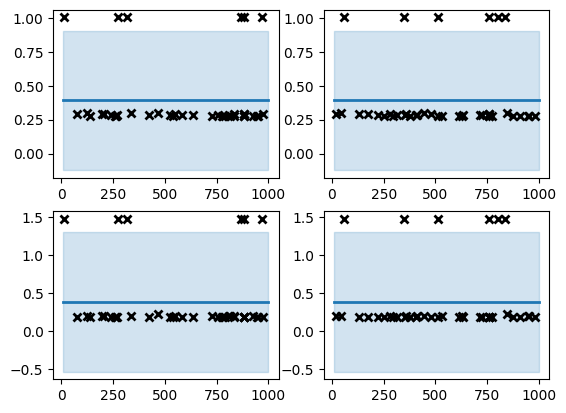

x_best =  [ 83.9423645  975.56779544]
acq_best =  [0.10260343 0.18307416]
C = [ 83.9423645  975.56779544]
C = [84, 976]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 423041335296.0000 - mae: 538371.5000 - mse: 423040843776.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 423041302528.0000 - mae: 538371.3750 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 423041138688.0000 - mae: 538371.6250 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 423041269760.0000 - mae: 538371.1875 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
51

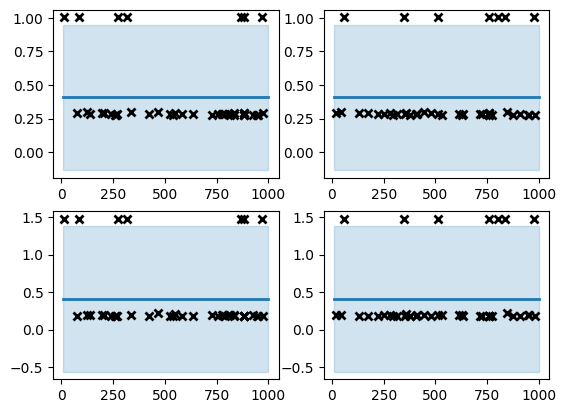

x_best =  [779.74996236 477.04306511]
acq_best =  [0.10811599 0.1930868 ]
C = [779.74996236 477.04306511]
C = [780, 477]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 111582887936.0000 - mae: 211976.3594 - mse: 111582699520.0000 - val_loss: 65012989952.0000 - val_mae: 174451.9688 - val_mse: 65012822016.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 62203043840.0000 - mae: 165585.5469 - mse: 62202900480.0000 - val_loss: 56777113600.0000 - val_mae: 153636.8125 - val_mse: 56776945664.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 59305930752.0000 - mae: 161814.9062 - mse: 59305775104.0000 - val_loss: 53514166272.0000 - val_mae: 154572.6250 - val_mse: 53514022912.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 58749394944.0000 - mae: 161395.7656 - mse: 58749243392.0000 - val_loss: 59350499328.0000 - val_mae: 156307.2344 - val_mse: 59350315008.0000
Epoch 5/6
517/517 [======

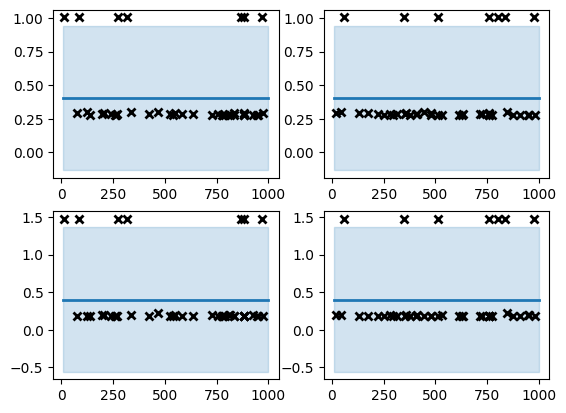

x_best =  [837.56976488 651.15556302]
acq_best =  [0.10709665 0.19113851]
C = [837.56976488 651.15556302]
C = [837, 651]
Epoch 1/6
517/517 [==============================] - 7s 10ms/step - loss: 423041302528.0000 - mae: 538371.5625 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 5s 9ms/step - loss: 423041302528.0000 - mae: 538371.7500 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 5s 9ms/step - loss: 423041368064.0000 - mae: 538371.6250 - mse: 423040843776.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 5s 10ms/step - loss: 423041269760.0000 - mae: 538371.5625 - mse: 423040811008.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6

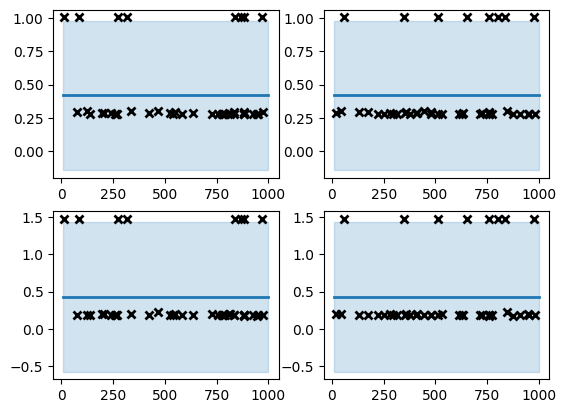

x_best =  [563.76356622 524.83652803]
acq_best =  [0.11182591 0.19958161]
C = [563.76356622 524.83652803]
C = [564, 525]
Epoch 1/6
517/517 [==============================] - 7s 9ms/step - loss: 150338142208.0000 - mae: 253012.1562 - mse: 150337880064.0000 - val_loss: 67442253824.0000 - val_mae: 161227.0469 - val_mse: 67442118656.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 61327241216.0000 - mae: 164331.9688 - mse: 61327089664.0000 - val_loss: 55409549312.0000 - val_mae: 153257.9062 - val_mse: 55409377280.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 57536663552.0000 - mae: 159509.6094 - mse: 57536512000.0000 - val_loss: 54976471040.0000 - val_mae: 155534.5156 - val_mse: 54976299008.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57188429824.0000 - mae: 159177.8750 - mse: 57188278272.0000 - val_loss: 53855129600.0000 - val_mae: 152295.4531 - val_mse: 53854978048.0000
Epoch 5/6
517/517 [======

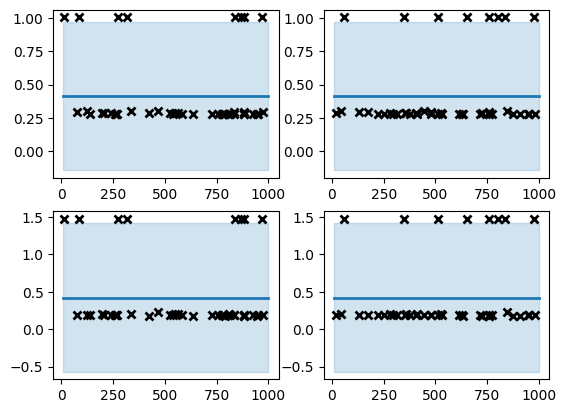

x_best =  [274.12056246 101.08060213]
acq_best =  [0.11082546 0.19774985]
C = [274.12056246 101.08060213]
C = [274, 101]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 148701560832.0000 - mae: 247812.0781 - mse: 148701347840.0000 - val_loss: 106198999040.0000 - val_mae: 204519.5938 - val_mse: 106198761472.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 77474570240.0000 - mae: 177865.1094 - mse: 77474349056.0000 - val_loss: 63600058368.0000 - val_mae: 163037.9844 - val_mse: 63599886336.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 61783621632.0000 - mae: 164707.7656 - mse: 61783470080.0000 - val_loss: 56982913024.0000 - val_mae: 158243.8906 - val_mse: 56982777856.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 59483926528.0000 - mae: 161803.0156 - mse: 59483770880.0000 - val_loss: 60714975232.0000 - val_mae: 174342.8750 - val_mse: 60714762240.0000
Epoch 5/6
517/517 [====

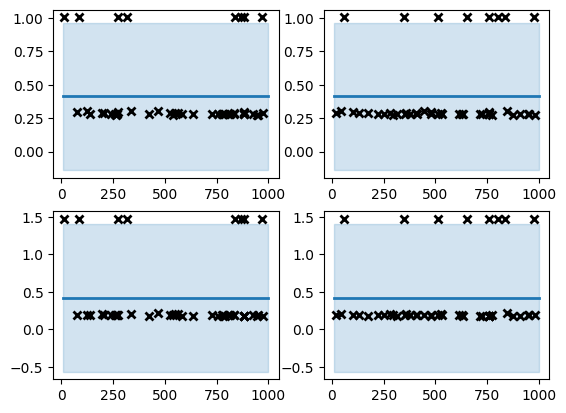

x_best =  [358.24355255 103.30346815]
acq_best =  [0.10979798 0.1960166 ]
C = [358.24355255 103.30346815]
C = [358, 103]
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 131037446144.0000 - mae: 230322.5938 - mse: 131037208576.0000 - val_loss: 96261816320.0000 - val_mae: 196186.7344 - val_mse: 96261595136.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 71074340864.0000 - mae: 171385.4531 - mse: 71074160640.0000 - val_loss: 56197124096.0000 - val_mae: 157381.3281 - val_mse: 56196947968.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 59273793536.0000 - mae: 161285.3906 - mse: 59273637888.0000 - val_loss: 59194847232.0000 - val_mae: 168585.8438 - val_mse: 59194679296.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 57823059968.0000 - mae: 159254.8125 - mse: 57822863360.0000 - val_loss: 53937491968.0000 - val_mae: 158068.0938 - val_mse: 53937356800.0000
Epoch 5/6
517/517 [======

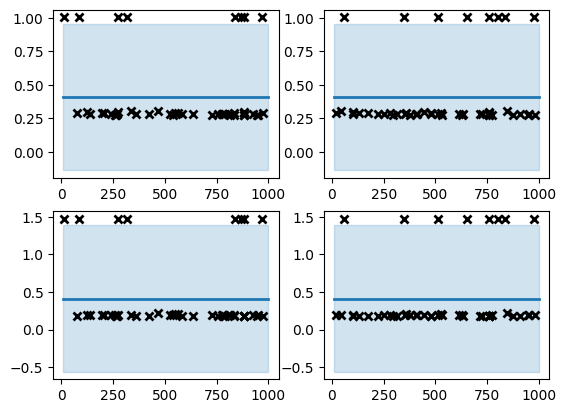

x_best =  [460.03583311 407.8869565 ]
acq_best =  [0.10886891 0.19434781]
C = [460.03583311 407.8869565 ]
C = [460, 408]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 423041138688.0000 - mae: 538371.5000 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 423041433600.0000 - mae: 538371.3125 - mse: 423040843776.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 423041499136.0000 - mae: 538371.3750 - mse: 423040811008.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 423041007616.0000 - mae: 538371.5000 - mse: 423040450560.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

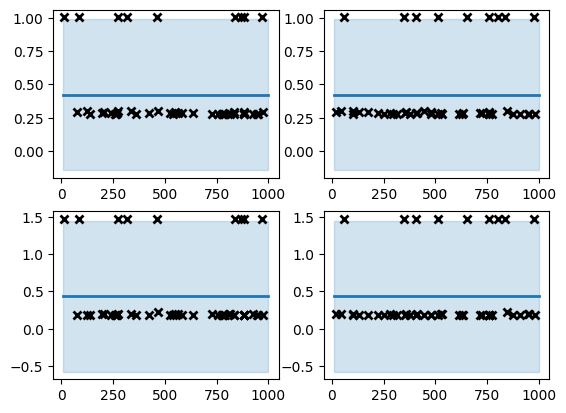

x_best =  [808.65491343 874.57159036]
acq_best =  [0.11301755 0.20175246]
C = [808.65491343 874.57159036]
C = [809, 875]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 97534664704.0000 - mae: 200624.3281 - mse: 97534435328.0000 - val_loss: 56275648512.0000 - val_mae: 157619.5000 - val_mse: 56275480576.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 61212041216.0000 - mae: 165721.3594 - mse: 61211848704.0000 - val_loss: 54682517504.0000 - val_mae: 158043.9688 - val_mse: 54682345472.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 58269544448.0000 - mae: 160603.5156 - mse: 58269405184.0000 - val_loss: 53192491008.0000 - val_mae: 155438.3438 - val_mse: 53192335360.0000
Epoch 4/6
517/517 [==============================] - 6s 12ms/step - loss: 57464913920.0000 - mae: 158998.9375 - mse: 57464758272.0000 - val_loss: 54287450112.0000 - val_mae: 151409.5938 - val_mse: 54287269888.0000
Epoch 5/6
517/517 [=======

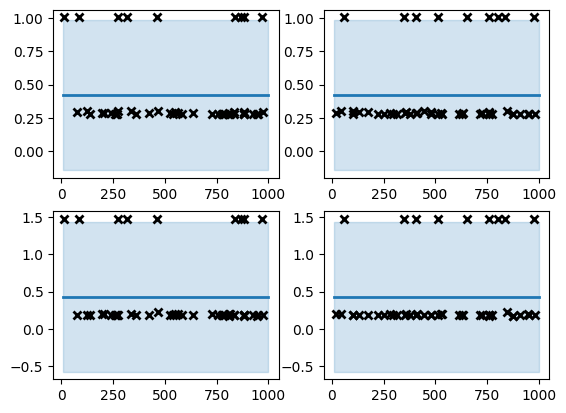

x_best =  [461.37989908 213.45367232]
acq_best =  [0.11212163 0.20011677]
C = [461.37989908 213.45367232]
C = [462, 214]
Epoch 1/6
517/517 [==============================] - 5s 6ms/step - loss: 119215489024.0000 - mae: 220106.4531 - mse: 119215276032.0000 - val_loss: 75719778304.0000 - val_mae: 168367.9531 - val_mse: 75719598080.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 63826747392.0000 - mae: 165873.2812 - mse: 63826583552.0000 - val_loss: 58822729728.0000 - val_mae: 156408.5625 - val_mse: 58822582272.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 58831704064.0000 - mae: 161507.2031 - mse: 58831507456.0000 - val_loss: 54949498880.0000 - val_mae: 154045.6875 - val_mse: 54949310464.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 58047107072.0000 - mae: 160001.4219 - mse: 58046955520.0000 - val_loss: 56261349376.0000 - val_mae: 164596.2031 - val_mse: 56261156864.0000
Epoch 5/6
517/517 [======

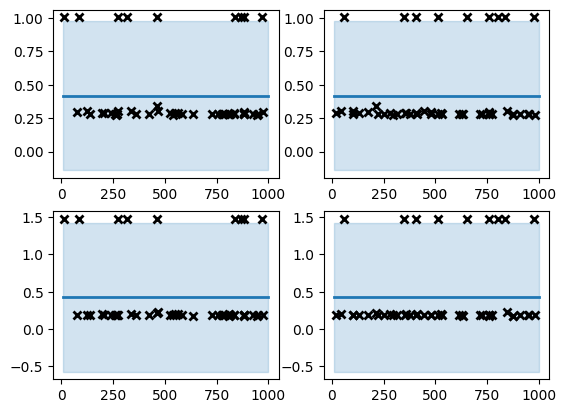

x_best =  [239.7634267  720.85323689]
acq_best =  [0.11107095 0.19848071]
C = [239.7634267  720.85323689]
C = [240, 721]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 129218658304.0000 - mae: 229758.0469 - mse: 129218387968.0000 - val_loss: 79424970752.0000 - val_mae: 199931.5312 - val_mse: 79424798720.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 62247526400.0000 - mae: 163265.0938 - mse: 62247354368.0000 - val_loss: 54054563840.0000 - val_mae: 155144.5469 - val_mse: 54054408192.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 58256515072.0000 - mae: 160376.0156 - mse: 58256355328.0000 - val_loss: 54330150912.0000 - val_mae: 158965.0625 - val_mse: 54330007552.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 57222852608.0000 - mae: 158943.5312 - mse: 57222696960.0000 - val_loss: 53328760832.0000 - val_mae: 155774.8438 - val_mse: 53328613376.0000
Epoch 5/6
517/517 [======

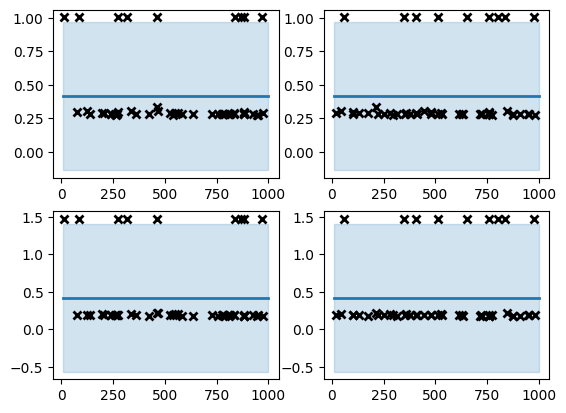

x_best =  [715.36457463 238.58953111]
acq_best =  [0.11022297 0.19690898]
C = [715.36457463 238.58953111]
C = [715, 238]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 110543855616.0000 - mae: 209642.4062 - mse: 110543618048.0000 - val_loss: 64792412160.0000 - val_mae: 175932.0469 - val_mse: 64792244224.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 62173601792.0000 - mae: 164588.0469 - mse: 62173421568.0000 - val_loss: 55677849600.0000 - val_mae: 154782.7656 - val_mse: 55677698048.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 58797142016.0000 - mae: 161018.3281 - mse: 58796965888.0000 - val_loss: 60287827968.0000 - val_mae: 154976.4219 - val_mse: 60287660032.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 57693609984.0000 - mae: 158733.2812 - mse: 57693458432.0000 - val_loss: 53843693568.0000 - val_mae: 151092.9219 - val_mse: 53843529728.0000
Epoch 5/6
517/517 [======

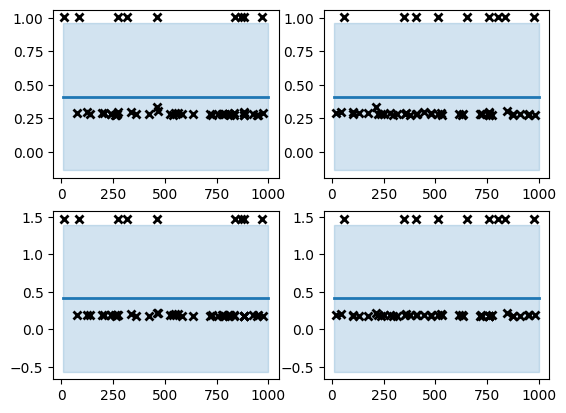

x_best =  [203.05756839 488.26968631]
acq_best =  [0.10937422 0.1954415 ]
C = [203.05756839 488.26968631]
C = [203, 488]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 122594156544.0000 - mae: 221739.5156 - mse: 122593968128.0000 - val_loss: 81067311104.0000 - val_mae: 197393.1719 - val_mse: 81067106304.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 65468928000.0000 - mae: 165988.0781 - mse: 65468764160.0000 - val_loss: 56638332928.0000 - val_mae: 158357.8594 - val_mse: 56638169088.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 59679006720.0000 - mae: 162542.4062 - mse: 59678892032.0000 - val_loss: 54236848128.0000 - val_mae: 155781.2969 - val_mse: 54236692480.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 58538692608.0000 - mae: 161161.5312 - mse: 58538520576.0000 - val_loss: 53445431296.0000 - val_mae: 154535.9219 - val_mse: 53445275648.0000
Epoch 5/6
517/517 [======

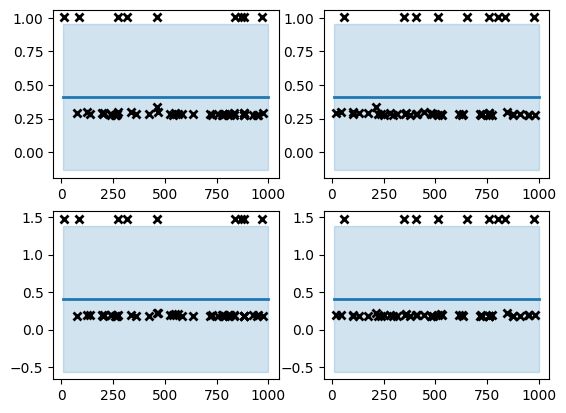

x_best =  [726.51742979 576.93927897]
acq_best =  [0.10855783 0.19396403]
C = [726.51742979 576.93927897]
C = [726, 577]
Epoch 1/6
517/517 [==============================] - 6s 10ms/step - loss: 102187991040.0000 - mae: 203823.4531 - mse: 102187843584.0000 - val_loss: 59237838848.0000 - val_mae: 158134.8750 - val_mse: 59237662720.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 62174040064.0000 - mae: 165535.8125 - mse: 62173884416.0000 - val_loss: 54803988480.0000 - val_mae: 156907.2031 - val_mse: 54803820544.0000
Epoch 3/6
517/517 [==============================] - 5s 9ms/step - loss: 59519918080.0000 - mae: 162328.6250 - mse: 59519741952.0000 - val_loss: 56267575296.0000 - val_mae: 159857.2656 - val_mse: 56267436032.0000
Epoch 4/6
517/517 [==============================] - 5s 10ms/step - loss: 58326552576.0000 - mae: 160982.6562 - mse: 58326364160.0000 - val_loss: 54061830144.0000 - val_mae: 154679.2188 - val_mse: 54061690880.0000
Epoch 5/6
517/517 [===

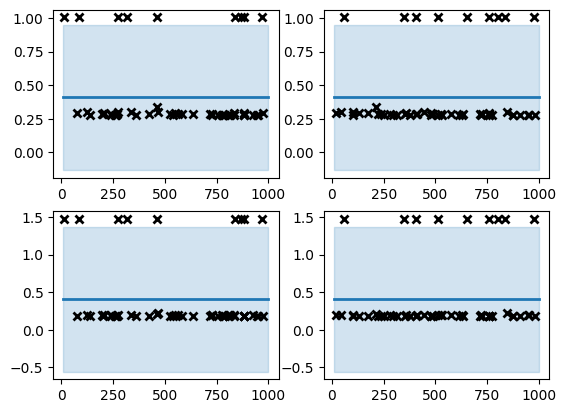

x_best =  [140.13461548 552.11591865]
acq_best =  [0.10772285 0.19249426]
C = [140.13461548 552.11591865]
C = [140, 552]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 129831600128.0000 - mae: 229955.3594 - mse: 129831354368.0000 - val_loss: 87977222144.0000 - val_mae: 190510.2500 - val_mse: 87977025536.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 68878639104.0000 - mae: 170223.6719 - mse: 68878499840.0000 - val_loss: 60752523264.0000 - val_mae: 161399.6875 - val_mse: 60752363520.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 60992434176.0000 - mae: 163999.1562 - mse: 60992258048.0000 - val_loss: 59308843008.0000 - val_mae: 160951.6406 - val_mse: 59308699648.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 59684106240.0000 - mae: 162060.8594 - mse: 59683930112.0000 - val_loss: 55304654848.0000 - val_mae: 158524.4531 - val_mse: 55304511488.0000
Epoch 5/6
517/517 [======

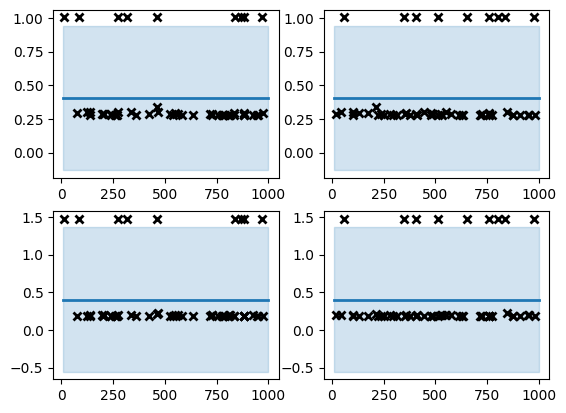

x_best =  [765.61762385 767.82399842]
acq_best =  [0.10686458 0.19102983]
C = [765.61762385 767.82399842]
C = [765, 768]
Epoch 1/6
517/517 [==============================] - 7s 11ms/step - loss: 99259310080.0000 - mae: 199226.5156 - mse: 99259097088.0000 - val_loss: 64948760576.0000 - val_mae: 176700.8906 - val_mse: 64948592640.0000
Epoch 2/6
517/517 [==============================] - 5s 9ms/step - loss: 59284013056.0000 - mae: 161918.0469 - mse: 59283865600.0000 - val_loss: 55158681600.0000 - val_mae: 152329.6250 - val_mse: 55158542336.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 58094088192.0000 - mae: 160210.0469 - mse: 58093924352.0000 - val_loss: 55847747584.0000 - val_mae: 153906.7031 - val_mse: 55847587840.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57378304000.0000 - mae: 158793.6719 - mse: 57378148352.0000 - val_loss: 57332858880.0000 - val_mae: 161039.2812 - val_mse: 57332686848.0000
Epoch 5/6
517/517 [=======

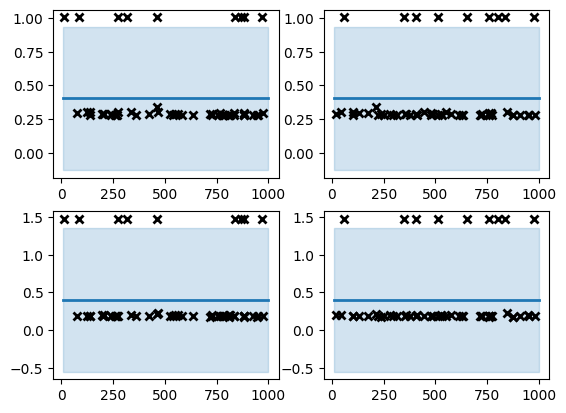

x_best =  [464.47355075  78.98134923]
acq_best =  [0.10605461 0.18965819]
C = [464.47355075  78.98134923]
C = [465, 79]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 129993555968.0000 - mae: 229864.0469 - mse: 129993285632.0000 - val_loss: 95785050112.0000 - val_mae: 190499.4844 - val_mse: 95784861696.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 71786561536.0000 - mae: 171173.0781 - mse: 71786405888.0000 - val_loss: 61590138880.0000 - val_mae: 158749.6719 - val_mse: 61589970944.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 60107321344.0000 - mae: 161387.0938 - mse: 60107186176.0000 - val_loss: 55218249728.0000 - val_mae: 158930.5625 - val_mse: 55218106368.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 58387103744.0000 - mae: 160237.2188 - mse: 58386964480.0000 - val_loss: 54690922496.0000 - val_mae: 155296.5000 - val_mse: 54690766848.0000
Epoch 5/6
517/517 [=======

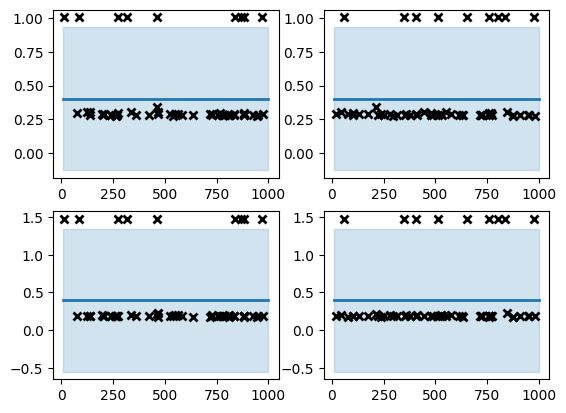

x_best =  [737.81574382 862.19851674]
acq_best =  [0.10529298 0.18830621]
C = [737.81574382 862.19851674]
C = [738, 862]
Epoch 1/6
517/517 [==============================] - 7s 11ms/step - loss: 105781084160.0000 - mae: 205244.3438 - mse: 105780830208.0000 - val_loss: 65350860800.0000 - val_mae: 163704.7344 - val_mse: 65350705152.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 61024210944.0000 - mae: 164387.3906 - mse: 61024055296.0000 - val_loss: 54836527104.0000 - val_mae: 159988.2500 - val_mse: 54836355072.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 58664116224.0000 - mae: 161787.9688 - mse: 58663948288.0000 - val_loss: 53626281984.0000 - val_mae: 152783.0156 - val_mse: 53626130432.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 57508265984.0000 - mae: 159399.5312 - mse: 57508114432.0000 - val_loss: 57005359104.0000 - val_mae: 160952.7031 - val_mse: 57005195264.0000
Epoch 5/6
517/517 [====

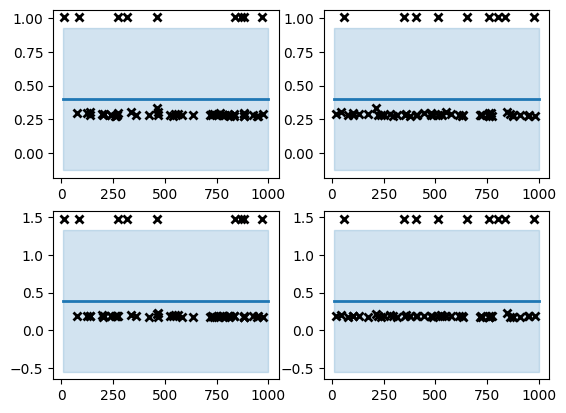

x_best =  [991.16088602 319.42943085]
acq_best =  [0.1045488  0.18699934]
C = [991.16088602 319.42943085]
C = [991, 320]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 106196942848.0000 - mae: 206055.0469 - mse: 106196762624.0000 - val_loss: 65791807488.0000 - val_mae: 161873.1562 - val_mse: 65791643648.0000
Epoch 2/6
517/517 [==============================] - 3s 7ms/step - loss: 61276332032.0000 - mae: 163676.4375 - mse: 61276151808.0000 - val_loss: 54726594560.0000 - val_mae: 157489.5938 - val_mse: 54726422528.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 59365634048.0000 - mae: 161289.2344 - mse: 59365453824.0000 - val_loss: 57728307200.0000 - val_mae: 166987.5938 - val_mse: 57728151552.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57386438656.0000 - mae: 158332.4688 - mse: 57386287104.0000 - val_loss: 54919602176.0000 - val_mae: 151963.0781 - val_mse: 54919446528.0000
Epoch 5/6
517/517 [======

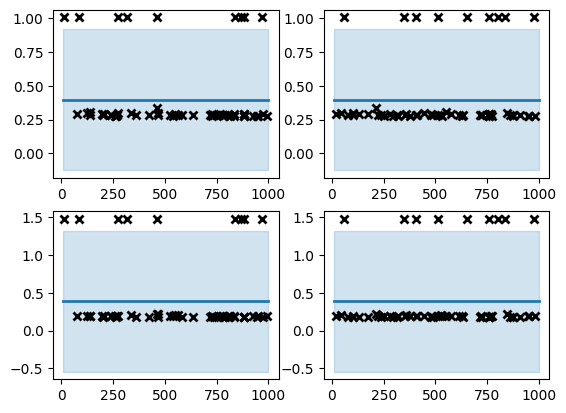

x_best =  [403.83194573 951.03154938]
acq_best =  [0.10382462 0.18567973]
C = [403.83194573 951.03154938]
C = [404, 951]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 110147190784.0000 - mae: 210898.2031 - mse: 110147002368.0000 - val_loss: 62026596352.0000 - val_mae: 158228.9531 - val_mse: 62026440704.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 61441728512.0000 - mae: 163843.0000 - mse: 61441519616.0000 - val_loss: 55948926976.0000 - val_mae: 160212.6094 - val_mse: 55948779520.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 59601903616.0000 - mae: 162995.4375 - mse: 59601764352.0000 - val_loss: 59073019904.0000 - val_mae: 154202.4062 - val_mse: 59072888832.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 58037190656.0000 - mae: 160751.4531 - mse: 58037035008.0000 - val_loss: 53175242752.0000 - val_mae: 154233.3906 - val_mse: 53175070720.0000
Epoch 5/6
517/517 [======

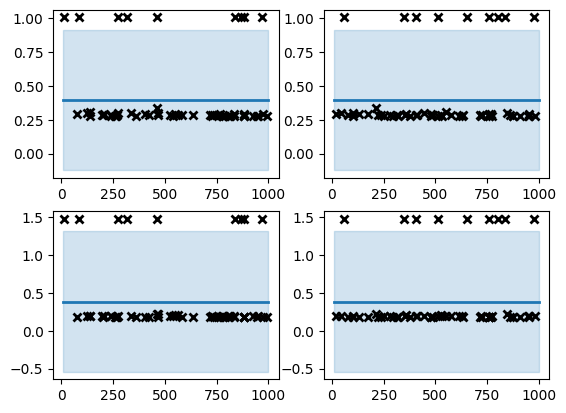

x_best =  [341.42716242 418.55811836]
acq_best =  [0.10309211 0.18437087]
C = [341.42716242 418.55811836]
C = [342, 419]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 423041400832.0000 - mae: 538371.5625 - mse: 423040876544.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 423041269760.0000 - mae: 538371.2500 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 423041171456.0000 - mae: 538371.4375 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 423041368064.0000 - mae: 538371.6875 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

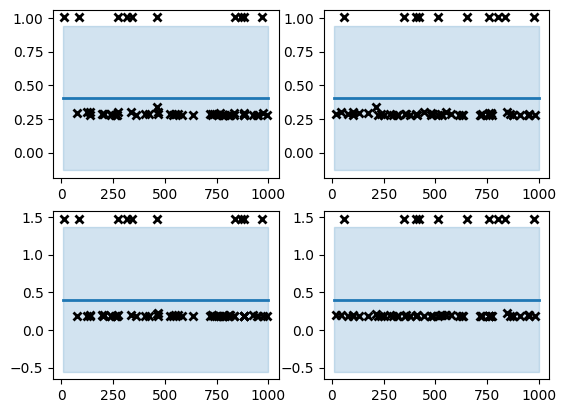

x_best =  [469.86735696 102.86894941]
acq_best =  [0.10685291 0.1911232 ]
C = [469.86735696 102.86894941]
C = [470, 103]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 128814792704.0000 - mae: 228621.8125 - mse: 128814538752.0000 - val_loss: 91274493952.0000 - val_mae: 199510.3906 - val_mse: 91274280960.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 69304524800.0000 - mae: 168904.8438 - mse: 69304393728.0000 - val_loss: 58064076800.0000 - val_mae: 156612.0938 - val_mse: 58063896576.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 60429869056.0000 - mae: 162402.4219 - mse: 60429733888.0000 - val_loss: 63368613888.0000 - val_mae: 183130.4219 - val_mse: 63368437760.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 59342192640.0000 - mae: 161530.6875 - mse: 59342041088.0000 - val_loss: 54663831552.0000 - val_mae: 159701.3594 - val_mse: 54663692288.0000
Epoch 5/6
517/517 [======

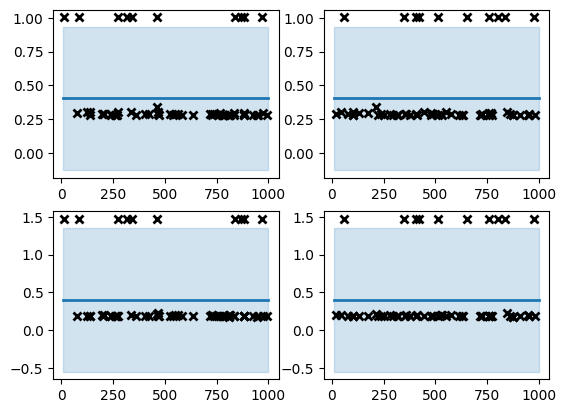

x_best =  [428.58015431 668.29066997]
acq_best =  [0.10617312 0.18988356]
C = [428.58015431 668.29066997]
C = [428, 669]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 112326819840.0000 - mae: 211731.7344 - mse: 112326598656.0000 - val_loss: 73296732160.0000 - val_mae: 172116.5156 - val_mse: 73296592896.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 61870194688.0000 - mae: 164637.2344 - mse: 61870034944.0000 - val_loss: 58619711488.0000 - val_mae: 155415.4062 - val_mse: 58619580416.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 58746159104.0000 - mae: 161984.9375 - mse: 58745995264.0000 - val_loss: 57392017408.0000 - val_mae: 168501.4375 - val_mse: 57391849472.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 57976094720.0000 - mae: 160632.3125 - mse: 57975926784.0000 - val_loss: 55033331712.0000 - val_mae: 160860.8125 - val_mse: 55033184256.0000
Epoch 5/6
517/517 [======

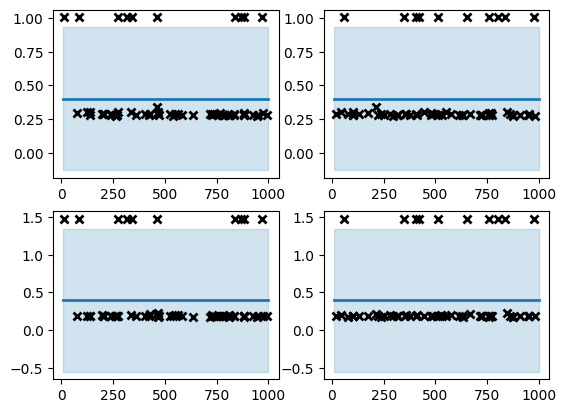

x_best =  [276.35397444 398.6471241 ]
acq_best =  [0.10550604 0.18858219]
C = [276.35397444 398.6471241 ]
C = [276, 399]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 123170340864.0000 - mae: 223618.6719 - mse: 123170127872.0000 - val_loss: 78939439104.0000 - val_mae: 180751.2188 - val_mse: 78939258880.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 65544183808.0000 - mae: 165838.8281 - mse: 65544019968.0000 - val_loss: 65030557696.0000 - val_mae: 171026.9531 - val_mse: 65030414336.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 59879596032.0000 - mae: 162237.2812 - mse: 59879444480.0000 - val_loss: 63594553344.0000 - val_mae: 164503.3438 - val_mse: 63594393600.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 58452422656.0000 - mae: 160932.8438 - mse: 58452250624.0000 - val_loss: 58863058944.0000 - val_mae: 157860.9375 - val_mse: 58862915584.0000
Epoch 5/6
517/517 [======

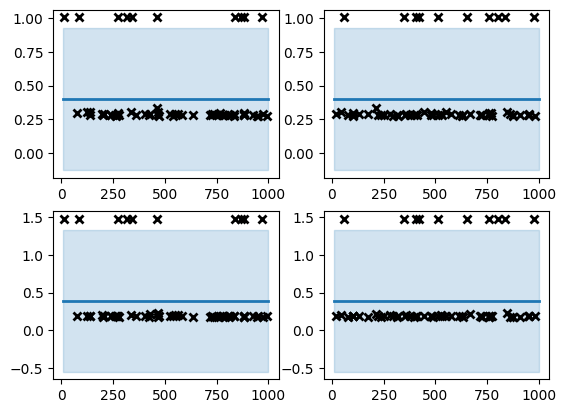

x_best =  [780.22933333 552.60686457]
acq_best =  [0.10480212 0.18737861]
C = [780.22933333 552.60686457]
C = [780, 552]
Epoch 1/6
517/517 [==============================] - 6s 10ms/step - loss: 100309467136.0000 - mae: 203258.1719 - mse: 100309254144.0000 - val_loss: 72921915392.0000 - val_mae: 200643.5781 - val_mse: 72921751552.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 60557209600.0000 - mae: 164206.7969 - mse: 60557045760.0000 - val_loss: 53482545152.0000 - val_mae: 154964.0781 - val_mse: 53482405888.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 59470835712.0000 - mae: 162205.9375 - mse: 59470704640.0000 - val_loss: 62521790464.0000 - val_mae: 183519.5156 - val_mse: 62521593856.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 58239025152.0000 - mae: 160265.3125 - mse: 58238885888.0000 - val_loss: 57839407104.0000 - val_mae: 152302.8125 - val_mse: 57839271936.0000
Epoch 5/6
517/517 [=====

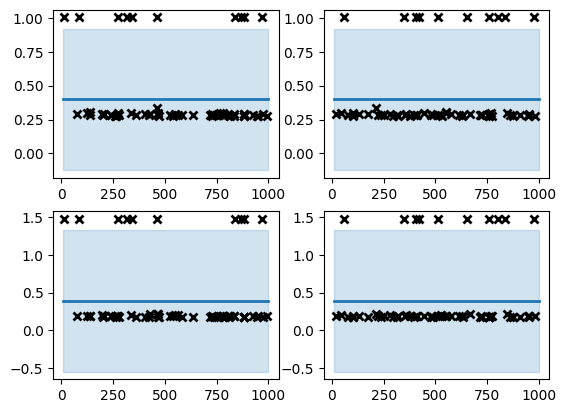

x_best =  [876.54853626  99.81386996]
acq_best =  [0.10411013 0.18618613]
C = [876.54853626  99.81386996]
C = [877, 100]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 119054409728.0000 - mae: 216853.0156 - mse: 119054180352.0000 - val_loss: 70141460480.0000 - val_mae: 166315.3906 - val_mse: 70141272064.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 63760564224.0000 - mae: 164739.6094 - mse: 63760375808.0000 - val_loss: 57564078080.0000 - val_mae: 155860.0156 - val_mse: 57563934720.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 60553560064.0000 - mae: 162497.5625 - mse: 60553392128.0000 - val_loss: 55833677824.0000 - val_mae: 159957.5469 - val_mse: 55833518080.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 58387185664.0000 - mae: 159541.0156 - mse: 58387046400.0000 - val_loss: 54978469888.0000 - val_mae: 153253.6250 - val_mse: 54978338816.0000
Epoch 5/6
517/517 [======

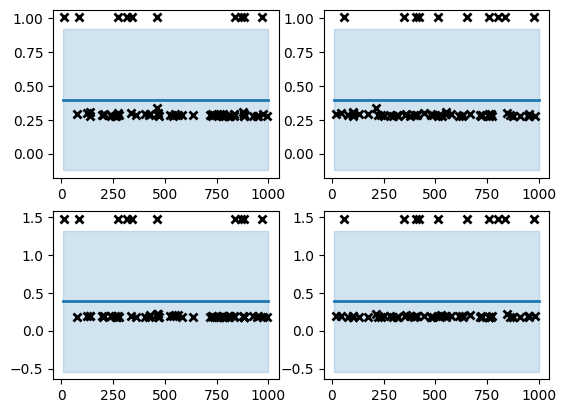

x_best =  [573.84127305 283.07131854]
acq_best =  [0.10343123 0.18501391]
C = [573.84127305 283.07131854]
C = [574, 283]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 117780930560.0000 - mae: 216872.7188 - mse: 117780709376.0000 - val_loss: 70732701696.0000 - val_mae: 163404.6562 - val_mse: 70732521472.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 63310381056.0000 - mae: 165219.3125 - mse: 63310217216.0000 - val_loss: 56300892160.0000 - val_mae: 157141.7969 - val_mse: 56300752896.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 59239690240.0000 - mae: 161576.0938 - mse: 59239526400.0000 - val_loss: 54374899712.0000 - val_mae: 158514.2188 - val_mse: 54374744064.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 58083524608.0000 - mae: 160517.9531 - mse: 58083348480.0000 - val_loss: 61833113600.0000 - val_mae: 176060.4844 - val_mse: 61832925184.0000
Epoch 5/6
517/517 [======

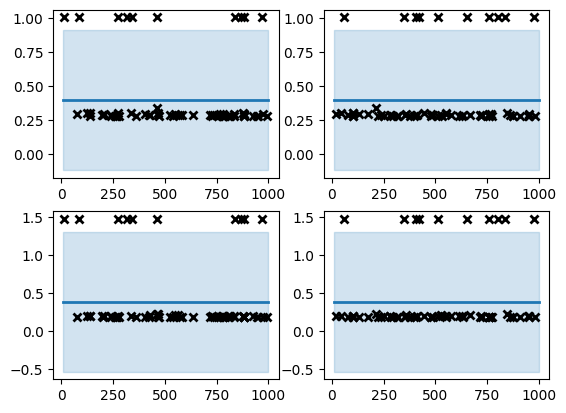

x_best =  [588.96200234 352.96802278]
acq_best =  [0.10278773 0.18387953]
C = [588.96200234 352.96802278]
C = [589, 353]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 423041040384.0000 - mae: 538371.3750 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 423041204224.0000 - mae: 538371.4375 - mse: 423040548864.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 423041531904.0000 - mae: 538371.6250 - mse: 423041007616.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 423041335296.0000 - mae: 538371.2500 - mse: 423040843776.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

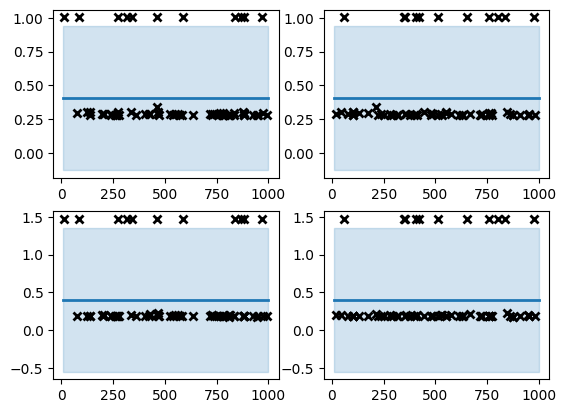

x_best =  [546.96238234 415.26838353]
acq_best =  [0.106187   0.18997789]
C = [546.96238234 415.26838353]
C = [547, 415]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 117606744064.0000 - mae: 216497.8906 - mse: 117606572032.0000 - val_loss: 76535783424.0000 - val_mae: 169118.0000 - val_mse: 76535619584.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 62716518400.0000 - mae: 164767.2812 - mse: 62716350464.0000 - val_loss: 56889942016.0000 - val_mae: 154644.8281 - val_mse: 56889778176.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 58781233152.0000 - mae: 160657.6250 - mse: 58781085696.0000 - val_loss: 54180499456.0000 - val_mae: 151939.1875 - val_mse: 54180352000.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57277923328.0000 - mae: 158817.0156 - mse: 57277779968.0000 - val_loss: 55827709952.0000 - val_mae: 164244.5000 - val_mse: 55827537920.0000
Epoch 5/6
517/517 [======

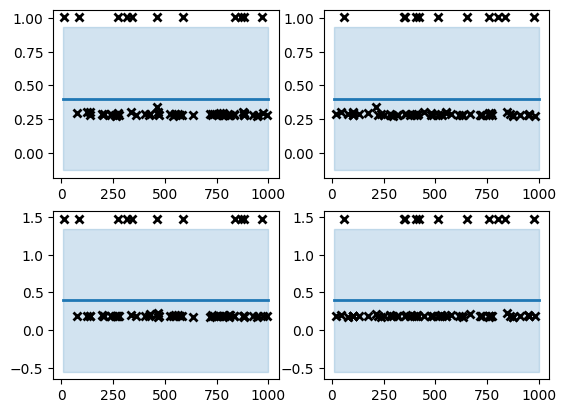

x_best =  [661.54338423 131.99502911]
acq_best =  [0.10553525 0.18884254]
C = [661.54338423 131.99502911]
C = [662, 132]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 115681034240.0000 - mae: 216813.3750 - mse: 115680747520.0000 - val_loss: 66200076288.0000 - val_mae: 162278.1562 - val_mse: 66199900160.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 62895349760.0000 - mae: 164106.7969 - mse: 62895206400.0000 - val_loss: 56436035584.0000 - val_mae: 157395.3438 - val_mse: 56435888128.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 58615267328.0000 - mae: 160690.3750 - mse: 58615103488.0000 - val_loss: 53652336640.0000 - val_mae: 155844.1406 - val_mse: 53652201472.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 57346727936.0000 - mae: 158821.7656 - mse: 57346568192.0000 - val_loss: 53592342528.0000 - val_mae: 156454.0000 - val_mse: 53592199168.0000
Epoch 5/6
517/517 [======

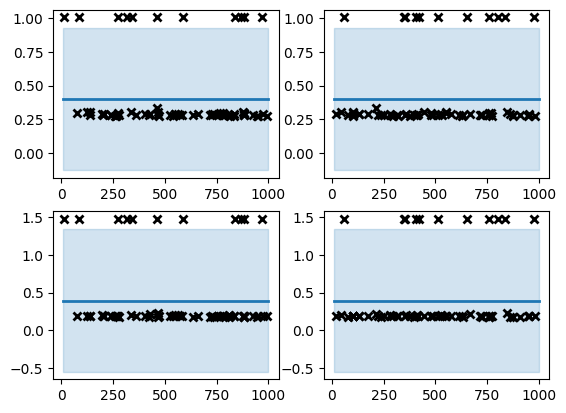

x_best =  [325.21377434 172.21715242]
acq_best =  [0.10491805 0.18769558]
C = [325.21377434 172.21715242]
C = [326, 172]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 130288623616.0000 - mae: 229898.8750 - mse: 130288353280.0000 - val_loss: 101160394752.0000 - val_mae: 215902.9219 - val_mse: 101160198144.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 73016623104.0000 - mae: 172647.7500 - mse: 73016442880.0000 - val_loss: 57877721088.0000 - val_mae: 164610.6719 - val_mse: 57877544960.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 59939667968.0000 - mae: 161786.1875 - mse: 59939512320.0000 - val_loss: 54640832512.0000 - val_mae: 155570.7500 - val_mse: 54640697344.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 58781798400.0000 - mae: 160927.4375 - mse: 58781634560.0000 - val_loss: 57093492736.0000 - val_mae: 161300.1250 - val_mse: 57093324800.0000
Epoch 5/6
517/517 [====

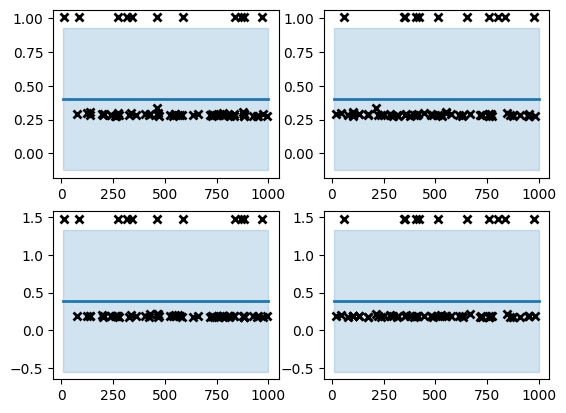

x_best =  [335.55069571 129.12415839]
acq_best =  [0.10428286 0.18664691]
C = [335.55069571 129.12415839]
C = [336, 129]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 128372236288.0000 - mae: 227629.6719 - mse: 128372023296.0000 - val_loss: 89917906944.0000 - val_mae: 188748.6562 - val_mse: 89917767680.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 69942419456.0000 - mae: 170521.0469 - mse: 69942263808.0000 - val_loss: 57484480512.0000 - val_mae: 156658.0469 - val_mse: 57484300288.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 60336414720.0000 - mae: 162861.5312 - mse: 60336234496.0000 - val_loss: 56220835840.0000 - val_mae: 154521.4688 - val_mse: 56220688384.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 57615253504.0000 - mae: 158866.3281 - mse: 57615097856.0000 - val_loss: 52944379904.0000 - val_mae: 152053.2031 - val_mse: 52944240640.0000
Epoch 5/6
517/517 [======

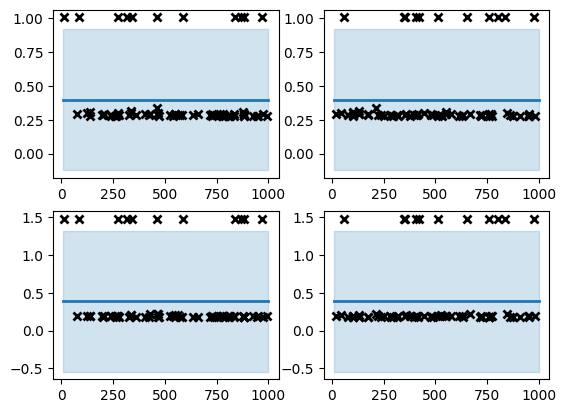

x_best =  [720.6579961  964.86333911]
acq_best =  [0.10363339 0.18555727]
C = [720.6579961  964.86333911]
C = [721, 964]
Epoch 1/6
517/517 [==============================] - 7s 11ms/step - loss: 423041433600.0000 - mae: 538371.6250 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 423041302528.0000 - mae: 538371.5000 - mse: 423040516096.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 423041466368.0000 - mae: 538371.4375 - mse: 423041040384.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 7s 13ms/step - loss: 423041138688.0000 - mae: 538371.5000 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5

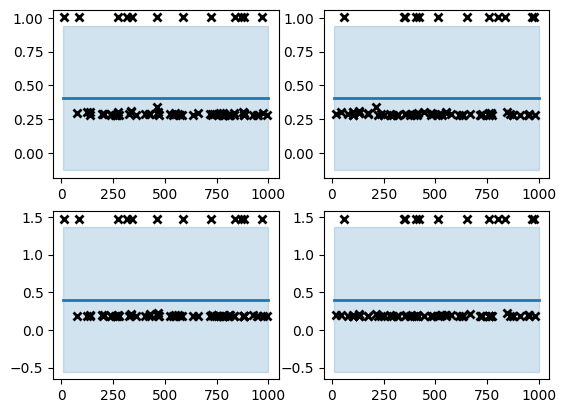

x_best =  [654.43058268 534.08123889]
acq_best =  [0.10673588 0.19113496]
C = [654.43058268 534.08123889]
C = [654, 534]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 423041204224.0000 - mae: 538371.4375 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 423041204224.0000 - mae: 538371.1875 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 423041269760.0000 - mae: 538371.5000 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 423041236992.0000 - mae: 538371.5625 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

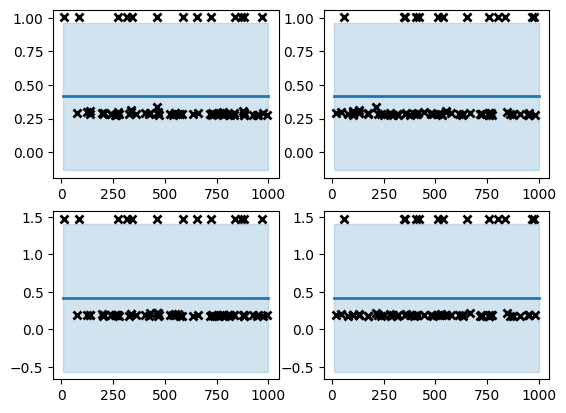

x_best =  [845.19635837  15.00839124]
acq_best =  [0.10956346 0.19620321]
C = [845.19635837  15.00839124]
C = [845, 15]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 130558959616.0000 - mae: 230321.0625 - mse: 130558713856.0000 - val_loss: 93300367360.0000 - val_mae: 187208.6875 - val_mse: 93300187136.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 72896012288.0000 - mae: 171202.1562 - mse: 72895864832.0000 - val_loss: 60124639232.0000 - val_mae: 166165.2656 - val_mse: 60124471296.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 62313484288.0000 - mae: 164498.0469 - mse: 62313316352.0000 - val_loss: 57120808960.0000 - val_mae: 155906.5781 - val_mse: 57120641024.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 59563769856.0000 - mae: 160280.3594 - mse: 59563610112.0000 - val_loss: 55308390400.0000 - val_mae: 152631.6875 - val_mse: 55308247040.0000
Epoch 5/6
517/517 [=======

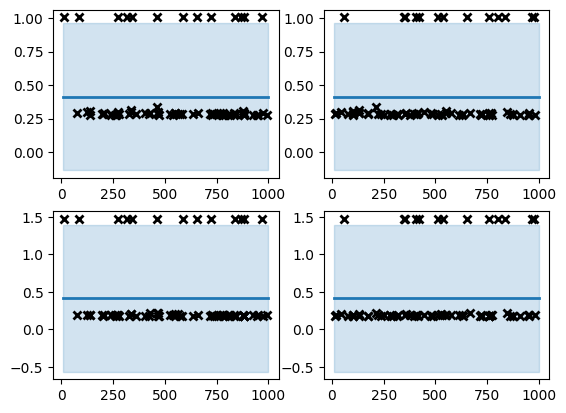

x_best =  [669.60386995 253.62409528]
acq_best =  [0.10898235 0.19514309]
C = [669.60386995 253.62409528]
C = [670, 254]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 115630637056.0000 - mae: 214545.2031 - mse: 115630456832.0000 - val_loss: 72768880640.0000 - val_mae: 166137.9219 - val_mse: 72768716800.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 62841663488.0000 - mae: 164715.3906 - mse: 62841479168.0000 - val_loss: 55301709824.0000 - val_mae: 159858.2500 - val_mse: 55301545984.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 58957795328.0000 - mae: 160537.9375 - mse: 58957623296.0000 - val_loss: 62486274048.0000 - val_mae: 162393.7812 - val_mse: 62486118400.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 57967329280.0000 - mae: 159382.7031 - mse: 57967128576.0000 - val_loss: 54470688768.0000 - val_mae: 151632.0469 - val_mse: 54470553600.0000
Epoch 5/6
517/517 [======

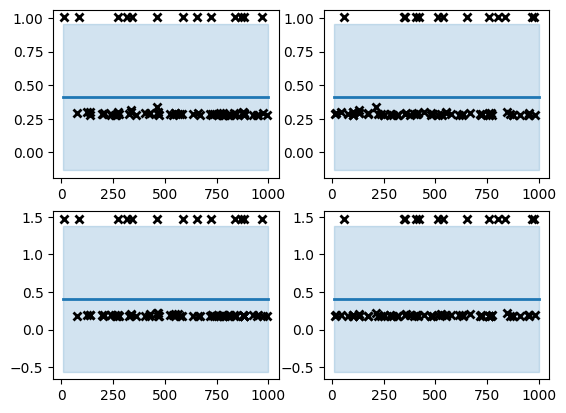

x_best =  [970.4883029  967.68023171]
acq_best =  [0.10842253 0.19415184]
C = [970.4883029  967.68023171]
C = [970, 968]
Epoch 1/6
517/517 [==============================] - 10s 17ms/step - loss: 423041105920.0000 - mae: 538371.5000 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 7s 14ms/step - loss: 423041171456.0000 - mae: 538371.3750 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 6s 11ms/step - loss: 423041040384.0000 - mae: 538371.6250 - mse: 423040483328.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 423041105920.0000 - mae: 538371.5000 - mse: 423040483328.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5

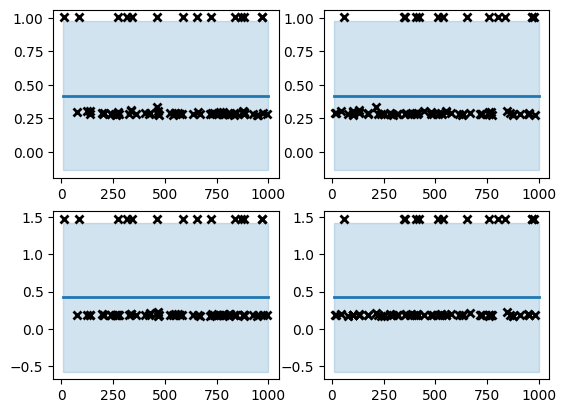

x_best =  [870.92520462  47.15404815]
acq_best =  [0.11102817 0.19883477]
C = [870.92520462  47.15404815]
C = [871, 47]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 118153207808.0000 - mae: 217896.9375 - mse: 118153027584.0000 - val_loss: 71780278272.0000 - val_mae: 172810.6406 - val_mse: 71780122624.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 65106374656.0000 - mae: 166414.7656 - mse: 65106186240.0000 - val_loss: 60657516544.0000 - val_mae: 174345.1562 - val_mse: 60657336320.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 60185214976.0000 - mae: 163179.6094 - mse: 60185051136.0000 - val_loss: 54318587904.0000 - val_mae: 154119.1406 - val_mse: 54318432256.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 58978287616.0000 - mae: 160821.4062 - mse: 58978127872.0000 - val_loss: 54165929984.0000 - val_mae: 152238.9375 - val_mse: 54165798912.0000
Epoch 5/6
517/517 [=======

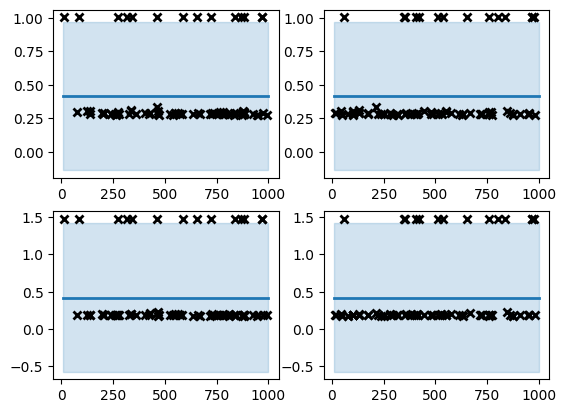

x_best =  [809.87684641 111.35673194]
acq_best =  [0.11050021 0.1978447 ]
C = [809.87684641 111.35673194]
C = [809, 111]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 116565909504.0000 - mae: 216858.8281 - mse: 116565663744.0000 - val_loss: 68127830016.0000 - val_mae: 167108.2188 - val_mse: 68127649792.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 62710194176.0000 - mae: 163709.6406 - mse: 62710018048.0000 - val_loss: 55448612864.0000 - val_mae: 154709.2500 - val_mse: 55448461312.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 58636267520.0000 - mae: 160561.1406 - mse: 58636136448.0000 - val_loss: 54429777920.0000 - val_mae: 151491.6562 - val_mse: 54429634560.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 57793835008.0000 - mae: 159191.8906 - mse: 57793658880.0000 - val_loss: 52970082304.0000 - val_mae: 154075.2344 - val_mse: 52969918464.0000
Epoch 5/6
517/517 [======

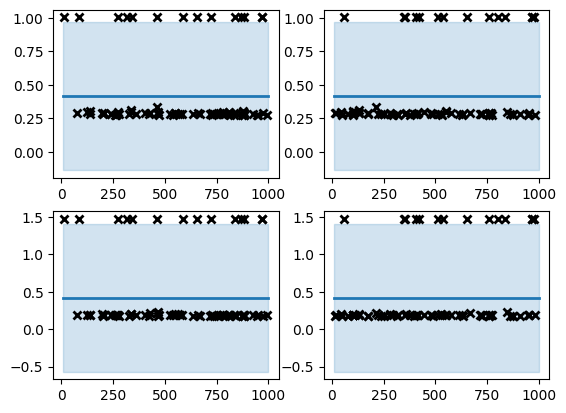

x_best =  [272.90209972 430.28799503]
acq_best =  [0.10990298 0.19685978]
C = [272.90209972 430.28799503]
C = [272, 430]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 423041531904.0000 - mae: 538371.5625 - mse: 423040876544.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 423041007616.0000 - mae: 538371.5000 - mse: 423040516096.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 423041204224.0000 - mae: 538371.5000 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 423041400832.0000 - mae: 538371.5000 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

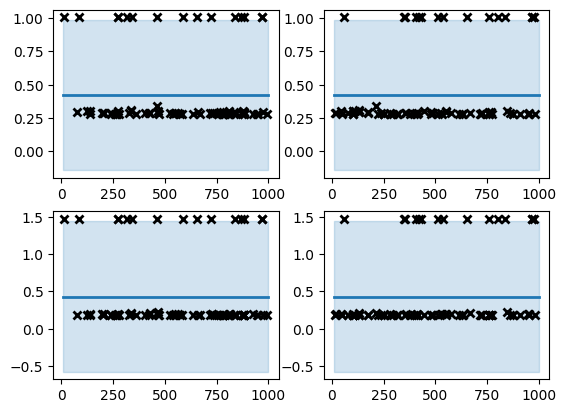

x_best =  [603.06371599 181.92662176]
acq_best =  [0.11232458 0.20117108]
C = [603.06371599 181.92662176]
C = [604, 182]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 121307725824.0000 - mae: 220815.1562 - mse: 121307553792.0000 - val_loss: 72355807232.0000 - val_mae: 164141.8438 - val_mse: 72355627008.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 63092064256.0000 - mae: 165227.9688 - mse: 63091900416.0000 - val_loss: 55558107136.0000 - val_mae: 160220.6562 - val_mse: 55557935104.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 59432185856.0000 - mae: 162298.8281 - mse: 59432034304.0000 - val_loss: 54933172224.0000 - val_mae: 156444.7969 - val_mse: 54933004288.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 57918435328.0000 - mae: 160193.9375 - mse: 57918259200.0000 - val_loss: 56263798784.0000 - val_mae: 153752.1562 - val_mse: 56263634944.0000
Epoch 5/6
517/517 [======

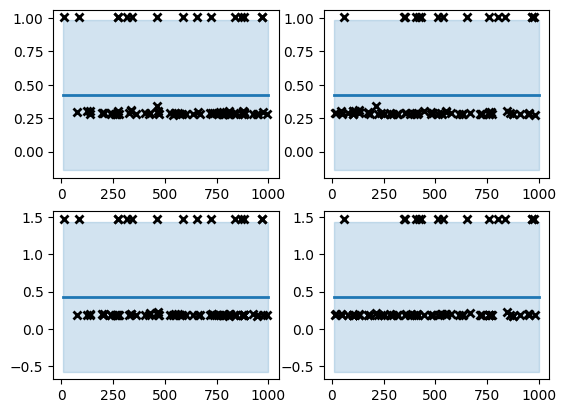

x_best =  [879.38632303 701.37481442]
acq_best =  [0.11179243 0.20020485]
C = [879.38632303 701.37481442]
C = [879, 701]
Epoch 1/6
517/517 [==============================] - 6s 9ms/step - loss: 112801923072.0000 - mae: 210806.2031 - mse: 112801660928.0000 - val_loss: 60351836160.0000 - val_mae: 161940.3594 - val_mse: 60351688704.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 61848117248.0000 - mae: 165777.5156 - mse: 61847941120.0000 - val_loss: 64254377984.0000 - val_mae: 176965.2812 - val_mse: 64254218240.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 59306385408.0000 - mae: 161957.9219 - mse: 59306225664.0000 - val_loss: 54015430656.0000 - val_mae: 150910.2188 - val_mse: 54015311872.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 57584738304.0000 - mae: 159411.3125 - mse: 57584582656.0000 - val_loss: 56911323136.0000 - val_mae: 167317.7344 - val_mse: 56911151104.0000
Epoch 5/6
517/517 [======

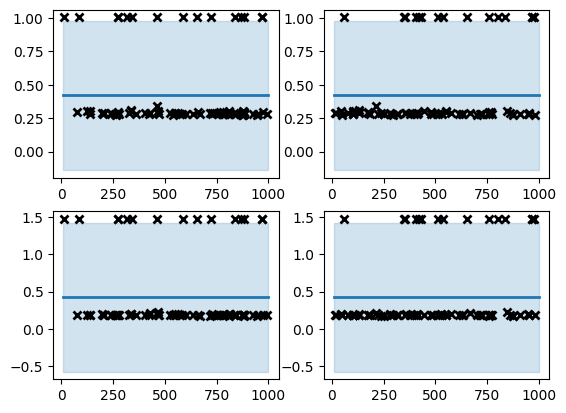

x_best =  [537.60305456  68.14333306]
acq_best =  [0.11128514 0.19925346]
C = [537.60305456  68.14333306]
C = [537, 68]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 423041302528.0000 - mae: 538371.5000 - mse: 423040811008.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 423041007616.0000 - mae: 538371.5625 - mse: 423040352256.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 423041302528.0000 - mae: 538371.3125 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 423041335296.0000 - mae: 538371.7500 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
51

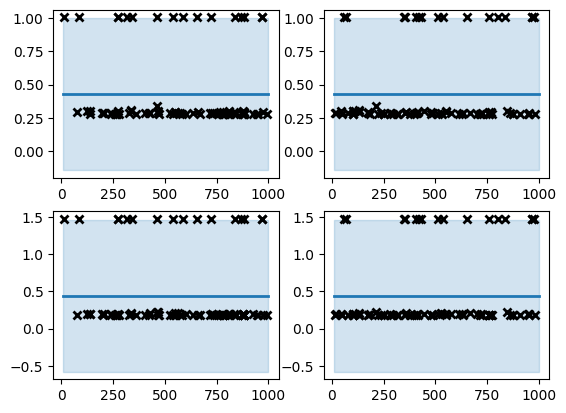

x_best =  [336.55562528 783.19381395]
acq_best =  [0.1135397  0.20328517]
C = [336.55562528 783.19381395]
C = [337, 783]
Epoch 1/6
517/517 [==============================] - 2s 4ms/step - loss: 112224256000.0000 - mae: 212879.6562 - mse: 112224059392.0000 - val_loss: 63344300032.0000 - val_mae: 167021.6094 - val_mse: 63344185344.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 60895895552.0000 - mae: 162286.1406 - mse: 60895739904.0000 - val_loss: 53947047936.0000 - val_mae: 155602.7812 - val_mse: 53946884096.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 57552244736.0000 - mae: 159991.3594 - mse: 57552048128.0000 - val_loss: 53810503680.0000 - val_mae: 154412.0781 - val_mse: 53810331648.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 57379205120.0000 - mae: 159210.3750 - mse: 57379020800.0000 - val_loss: 55361826816.0000 - val_mae: 152177.2344 - val_mse: 55361675264.0000
Epoch 5/6
517/517 [======

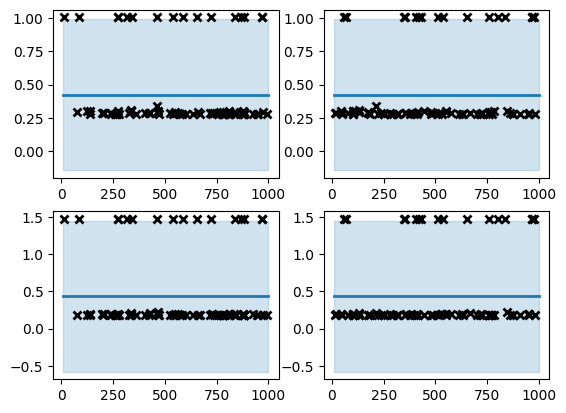

x_best =  [791.10328978 284.8574453 ]
acq_best =  [0.11298349 0.20233152]
C = [791.10328978 284.8574453 ]
C = [791, 285]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 423041204224.0000 - mae: 538371.4375 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 423041269760.0000 - mae: 538371.5625 - mse: 423040811008.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 423041204224.0000 - mae: 538371.6875 - mse: 423040647168.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 423041335296.0000 - mae: 538371.5000 - mse: 423040712704.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

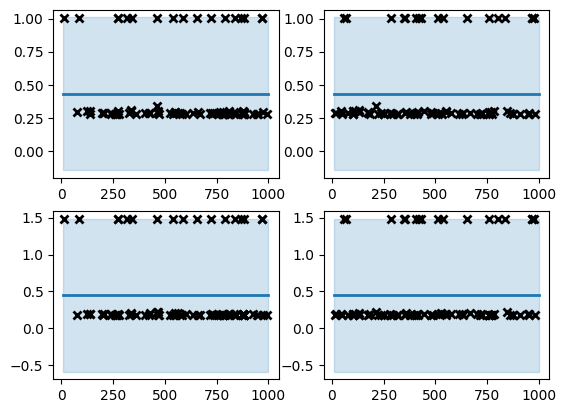

x_best =  [759.33351617 378.28333368]
acq_best =  [0.1151008  0.20606392]
C = [759.33351617 378.28333368]
C = [759, 378]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 423041138688.0000 - mae: 538371.6875 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 423041269760.0000 - mae: 538371.3750 - mse: 423040385024.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 423041171456.0000 - mae: 538371.4375 - mse: 423040614400.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 423041433600.0000 - mae: 538371.5625 - mse: 423040843776.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

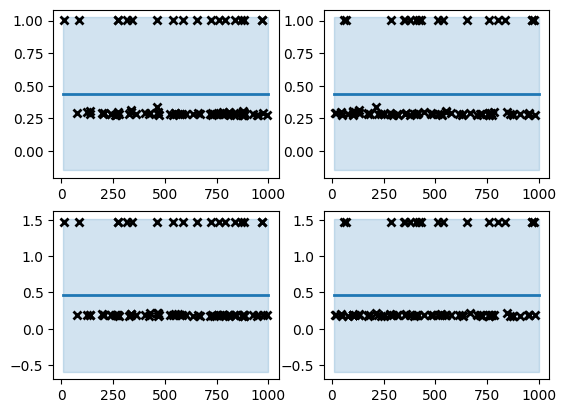

x_best =  [817.03749755 614.36468945]
acq_best =  [0.11701388 0.20955998]
C = [817.03749755 614.36468945]
C = [817, 614]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 103737958400.0000 - mae: 204685.5938 - mse: 103737729024.0000 - val_loss: 58768621568.0000 - val_mae: 157006.0469 - val_mse: 58768461824.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 60765487104.0000 - mae: 163432.5469 - mse: 60765306880.0000 - val_loss: 57675153408.0000 - val_mae: 164526.7812 - val_mse: 57674997760.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 58358886400.0000 - mae: 160895.7500 - mse: 58358734848.0000 - val_loss: 54244560896.0000 - val_mae: 156641.8906 - val_mse: 54244401152.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 57654751232.0000 - mae: 160194.3750 - mse: 57654599680.0000 - val_loss: 53335904256.0000 - val_mae: 155987.1406 - val_mse: 53335748608.0000
Epoch 5/6
517/517 [======

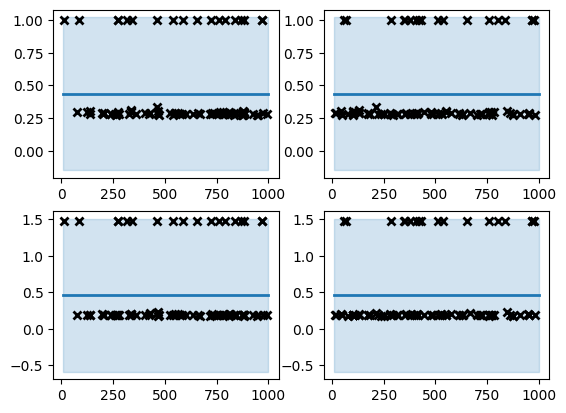

x_best =  [359.32589665 333.53218706]
acq_best =  [0.11650628 0.20867502]
C = [359.32589665 333.53218706]
C = [359, 333]
Epoch 1/6
517/517 [==============================] - 4s 4ms/step - loss: 423041236992.0000 - mae: 538371.5625 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 423041073152.0000 - mae: 538371.4375 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 423041433600.0000 - mae: 538371.1875 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 423041236992.0000 - mae: 538371.5000 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

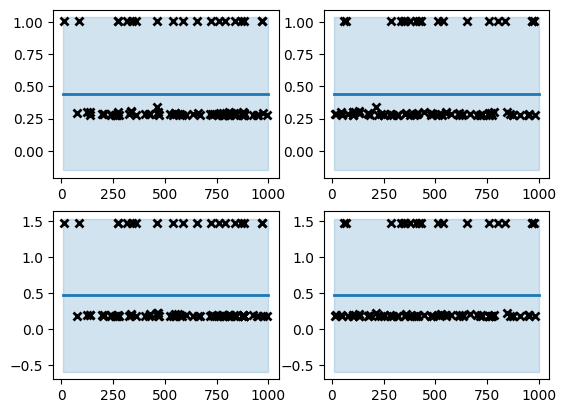

x_best =  [437.04407601 236.75452503]
acq_best =  [0.11831644 0.2119259 ]
C = [437.04407601 236.75452503]
C = [437, 237]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 423041302528.0000 - mae: 538371.3125 - mse: 423040876544.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 423041105920.0000 - mae: 538371.1875 - mse: 423040516096.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 423041171456.0000 - mae: 538371.3125 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 423041236992.0000 - mae: 538371.5000 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

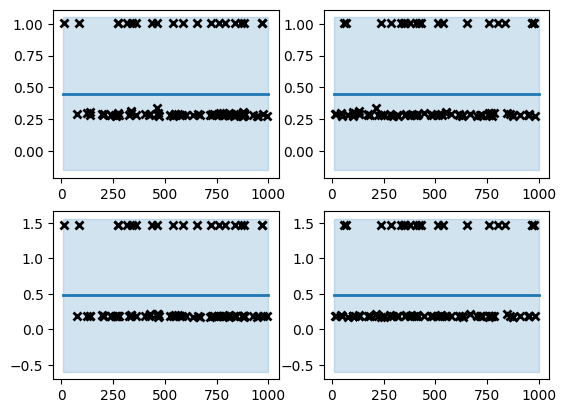

x_best =  [864.93712972 631.52543437]
acq_best =  [0.12001034 0.21497028]
C = [864.93712972 631.52543437]
C = [865, 632]
Epoch 1/6
517/517 [==============================] - 5s 9ms/step - loss: 104592138240.0000 - mae: 204644.2656 - mse: 104591966208.0000 - val_loss: 58362552320.0000 - val_mae: 165875.8438 - val_mse: 58362396672.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 61305577472.0000 - mae: 164434.0156 - mse: 61305393152.0000 - val_loss: 62276288512.0000 - val_mae: 178951.4062 - val_mse: 62276083712.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 57504989184.0000 - mae: 159281.8906 - mse: 57504813056.0000 - val_loss: 54462386176.0000 - val_mae: 152945.5312 - val_mse: 54462214144.0000
Epoch 4/6
517/517 [==============================] - 5s 9ms/step - loss: 57399787520.0000 - mae: 158416.0312 - mse: 57399599104.0000 - val_loss: 57067016192.0000 - val_mae: 154993.2500 - val_mse: 57066860544.0000
Epoch 5/6
517/517 [======

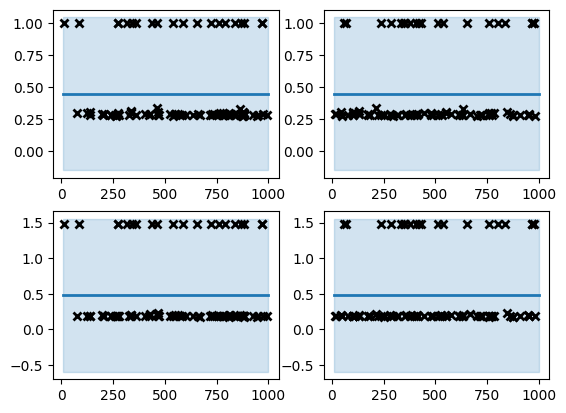

x_best =  [389.78908159 146.5588756 ]
acq_best =  [0.11944899 0.21407246]
C = [389.78908159 146.5588756 ]
C = [390, 147]
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 125299736576.0000 - mae: 224375.3906 - mse: 125299523584.0000 - val_loss: 84745256960.0000 - val_mae: 195046.1250 - val_mse: 84745035776.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 66604752896.0000 - mae: 166875.2969 - mse: 66604584960.0000 - val_loss: 58330468352.0000 - val_mae: 164081.3125 - val_mse: 58330292224.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 60595249152.0000 - mae: 163209.8594 - mse: 60595068928.0000 - val_loss: 55069642752.0000 - val_mae: 155110.2656 - val_mse: 55069491200.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 58643705856.0000 - mae: 161154.5156 - mse: 58643578880.0000 - val_loss: 53777928192.0000 - val_mae: 153578.4688 - val_mse: 53777788928.0000
Epoch 5/6
517/517 [======

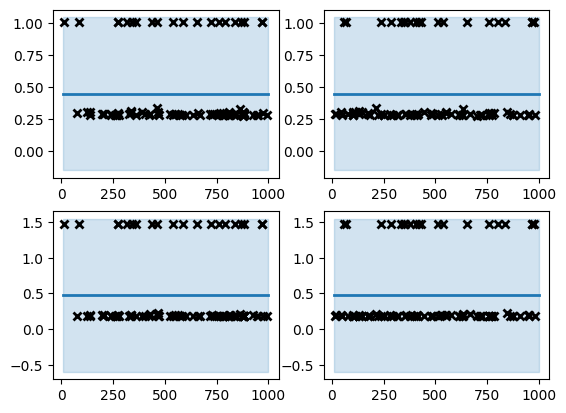

x_best =  [403.41159979 124.39423615]
acq_best =  [0.11893538 0.2132036 ]
C = [403.41159979 124.39423615]
C = [403, 125]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 423041073152.0000 - mae: 538371.5000 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 423041433600.0000 - mae: 538371.5000 - mse: 423040843776.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 423041269760.0000 - mae: 538371.3750 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 423041368064.0000 - mae: 538371.8125 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

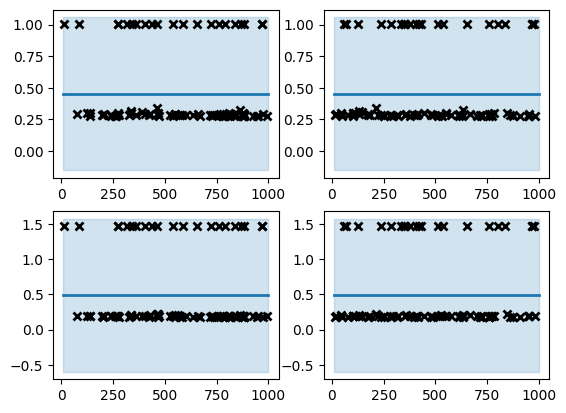

x_best =  [830.6441662  700.93212957]
acq_best =  [0.12052987 0.21607678]
C = [830.6441662  700.93212957]
C = [831, 701]
Epoch 1/6
517/517 [==============================] - 7s 11ms/step - loss: 105034072064.0000 - mae: 204989.7812 - mse: 105033883648.0000 - val_loss: 72517754880.0000 - val_mae: 167663.2500 - val_mse: 72517574656.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 61393362944.0000 - mae: 164877.2969 - mse: 61393211392.0000 - val_loss: 55771557888.0000 - val_mae: 158021.7812 - val_mse: 55771414528.0000
Epoch 3/6
517/517 [==============================] - 5s 9ms/step - loss: 59367317504.0000 - mae: 162402.6562 - mse: 59367149568.0000 - val_loss: 69148590080.0000 - val_mae: 166836.4375 - val_mse: 69148475392.0000
Epoch 4/6
517/517 [==============================] - 5s 9ms/step - loss: 58319187968.0000 - mae: 160957.7031 - mse: 58319056896.0000 - val_loss: 55546200064.0000 - val_mae: 152508.8750 - val_mse: 55546028032.0000
Epoch 5/6
517/517 [====

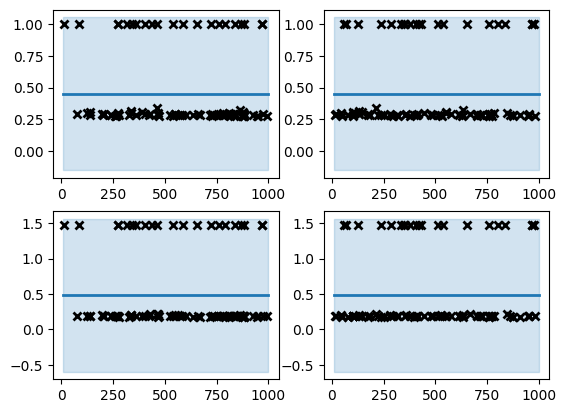

x_best =  [ 83.00893893 290.30894954]
acq_best =  [0.12006413 0.21528096]
C = [ 83.00893893 290.30894954]
C = [83, 291]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 423041269760.0000 - mae: 538371.5000 - mse: 423040745472.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 423041105920.0000 - mae: 538371.2500 - mse: 423040679936.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 423041400832.0000 - mae: 538371.8125 - mse: 423040876544.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 423041040384.0000 - mae: 538371.3125 - mse: 423040352256.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
51

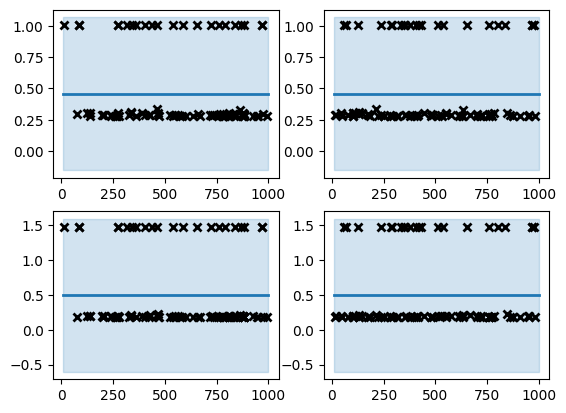

x_best =  [915.63271228  49.20919999]
acq_best =  [0.12156299 0.21794832]
C = [915.63271228  49.20919999]
C = [916, 49]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 124496625664.0000 - mae: 221485.6875 - mse: 124496420864.0000 - val_loss: 74641350656.0000 - val_mae: 180970.6719 - val_mse: 74641145856.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 64124583936.0000 - mae: 165058.4375 - mse: 64124428288.0000 - val_loss: 55798554624.0000 - val_mae: 155516.0156 - val_mse: 55798423552.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 58883248128.0000 - mae: 160444.8594 - mse: 58883072000.0000 - val_loss: 55443025920.0000 - val_mae: 155828.3438 - val_mse: 55442874368.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 57456701440.0000 - mae: 158508.9531 - mse: 57456562176.0000 - val_loss: 62515228672.0000 - val_mae: 170492.8438 - val_mse: 62515052544.0000
Epoch 5/6
517/517 [=======

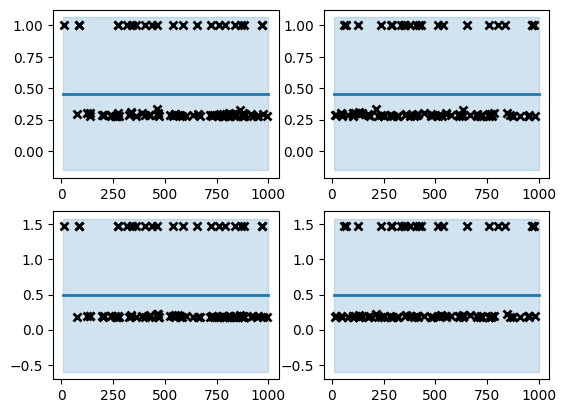

x_best =  [680.76647006 208.92720156]
acq_best =  [0.12108717 0.21714991]
C = [680.76647006 208.92720156]
C = [681, 209]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 115442032640.0000 - mae: 217372.1250 - mse: 115441795072.0000 - val_loss: 66752655360.0000 - val_mae: 177805.1875 - val_mse: 66752458752.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 62201274368.0000 - mae: 165049.2812 - mse: 62201081856.0000 - val_loss: 64462761984.0000 - val_mae: 164397.2812 - val_mse: 64462606336.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 59360899072.0000 - mae: 161715.0312 - mse: 59360727040.0000 - val_loss: 57339412480.0000 - val_mae: 157296.0156 - val_mse: 57339240448.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 57543118848.0000 - mae: 160031.4531 - mse: 57542967296.0000 - val_loss: 55469260800.0000 - val_mae: 153870.5469 - val_mse: 55469109248.0000
Epoch 5/6
517/517 [======

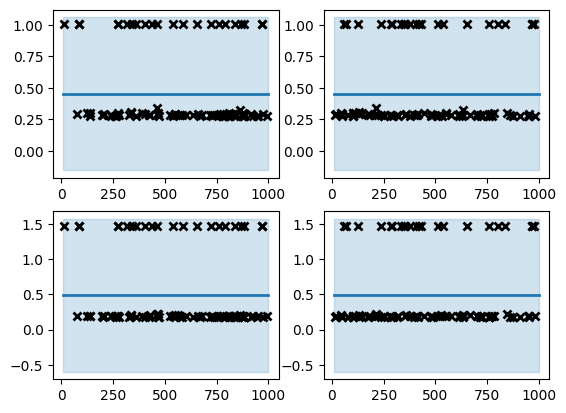

x_best =  [859.61608231 500.91686886]
acq_best =  [0.12066893 0.21637702]
C = [859.61608231 500.91686886]
C = [860, 501]
Epoch 1/6
517/517 [==============================] - 4s 7ms/step - loss: 104650653696.0000 - mae: 204782.7500 - mse: 104650489856.0000 - val_loss: 59019427840.0000 - val_mae: 162746.3594 - val_mse: 59019255808.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 60833914880.0000 - mae: 163382.4062 - mse: 60833738752.0000 - val_loss: 55718805504.0000 - val_mae: 154319.8750 - val_mse: 55718641664.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 58054832128.0000 - mae: 159595.0312 - mse: 58054660096.0000 - val_loss: 52571815936.0000 - val_mae: 153850.8750 - val_mse: 52571676672.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 56419913728.0000 - mae: 158042.4531 - mse: 56419745792.0000 - val_loss: 57063211008.0000 - val_mae: 153062.2031 - val_mse: 57063043072.0000
Epoch 5/6
517/517 [======

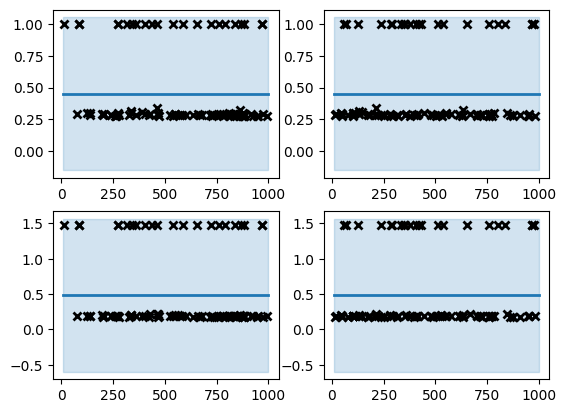

x_best =  [ 77.91254183 220.13545595]
acq_best =  [0.12025142 0.21554517]
C = [ 77.91254183 220.13545595]
C = [78, 221]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 139727978496.0000 - mae: 239344.2500 - mse: 139727667200.0000 - val_loss: 119304814592.0000 - val_mae: 228076.3281 - val_mse: 119304544256.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 96684408832.0000 - mae: 195285.9219 - mse: 96684187648.0000 - val_loss: 68615921664.0000 - val_mae: 163143.2656 - val_mse: 68615766016.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 63232811008.0000 - mae: 163996.4531 - mse: 63232602112.0000 - val_loss: 56968118272.0000 - val_mae: 159882.8281 - val_mse: 56967933952.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 59582763008.0000 - mae: 161702.6875 - mse: 59582582784.0000 - val_loss: 59080597504.0000 - val_mae: 162505.2188 - val_mse: 59080413184.0000
Epoch 5/6
517/517 [=====

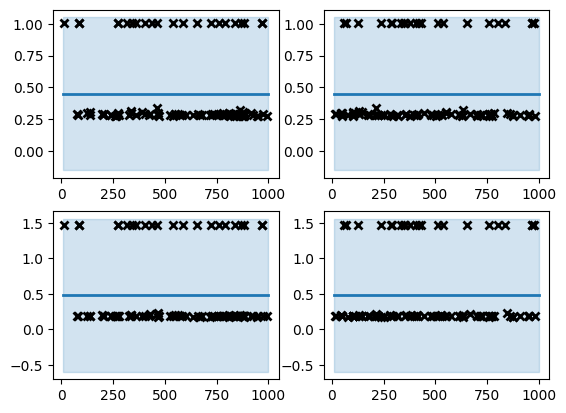

x_best =  [570.89231282 129.95479478]
acq_best =  [0.11981574 0.21476224]
C = [570.89231282 129.95479478]
C = [571, 130]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 122916585472.0000 - mae: 220436.9844 - mse: 122916282368.0000 - val_loss: 75514953728.0000 - val_mae: 168024.6094 - val_mse: 75514748928.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 66902921216.0000 - mae: 167590.2031 - mse: 66902769664.0000 - val_loss: 62124777472.0000 - val_mae: 161819.4531 - val_mse: 62124609536.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 60882341888.0000 - mae: 162141.2500 - mse: 60882194432.0000 - val_loss: 56492408832.0000 - val_mae: 154690.7344 - val_mse: 56492249088.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 59506774016.0000 - mae: 160946.9531 - mse: 59506610176.0000 - val_loss: 54725201920.0000 - val_mae: 158670.1719 - val_mse: 54725042176.0000
Epoch 5/6
517/517 [======

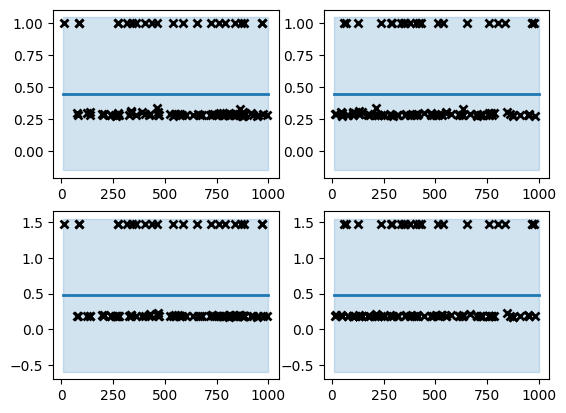

x_best =  [575.59404097 470.93950521]
acq_best =  [0.11936359 0.21399375]
C = [575.59404097 470.93950521]
C = [576, 471]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 121761693696.0000 - mae: 223329.6562 - mse: 121761472512.0000 - val_loss: 67441446912.0000 - val_mae: 161318.2812 - val_mse: 67441274880.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 61630558208.0000 - mae: 164056.7344 - mse: 61630423040.0000 - val_loss: 55417466880.0000 - val_mae: 157000.2969 - val_mse: 55417311232.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 58842357760.0000 - mae: 161011.9219 - mse: 58842181632.0000 - val_loss: 54677630976.0000 - val_mae: 158039.9688 - val_mse: 54677471232.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 57534394368.0000 - mae: 159524.6250 - mse: 57534242816.0000 - val_loss: 53170458624.0000 - val_mae: 153058.0781 - val_mse: 53170311168.0000
Epoch 5/6
517/517 [======

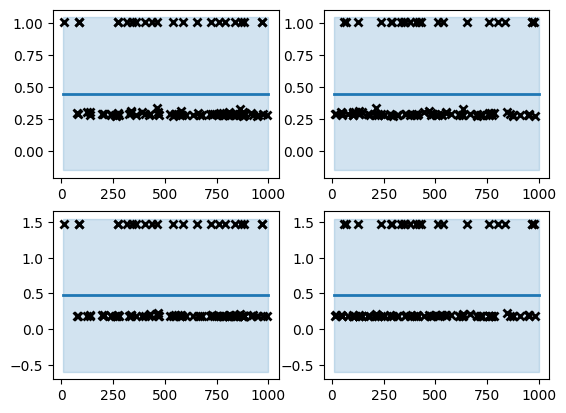

x_best =  [414.02838339 603.42271038]
acq_best =  [0.1188939  0.21320753]
C = [414.02838339 603.42271038]
C = [414, 604]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 114106728448.0000 - mae: 213951.3906 - mse: 114106507264.0000 - val_loss: 64005836800.0000 - val_mae: 162799.9531 - val_mse: 64005689344.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 62521552896.0000 - mae: 164237.5000 - mse: 62521384960.0000 - val_loss: 66577092608.0000 - val_mae: 187490.9375 - val_mse: 66576924672.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 59185250304.0000 - mae: 161824.2656 - mse: 59185102848.0000 - val_loss: 55833862144.0000 - val_mae: 163276.1719 - val_mse: 55833677824.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 56721928192.0000 - mae: 158007.9688 - mse: 56721756160.0000 - val_loss: 54584369152.0000 - val_mae: 156044.9219 - val_mse: 54584205312.0000
Epoch 5/6
517/517 [======

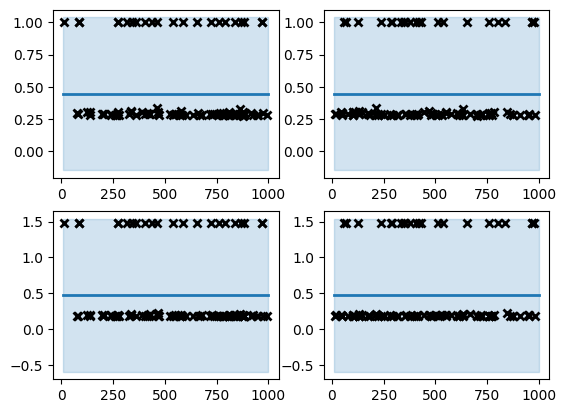

x_best =  [136.80628867 617.64050198]
acq_best =  [0.11844814 0.21248084]
C = [136.80628867 617.64050198]
C = [137, 618]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 423041204224.0000 - mae: 538371.5000 - mse: 423040581632.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 423041302528.0000 - mae: 538371.6250 - mse: 423040450560.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 423041236992.0000 - mae: 538371.5000 - mse: 423040876544.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 423041302528.0000 - mae: 538371.4375 - mse: 423040778240.0000 - val_loss: 430043430912.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

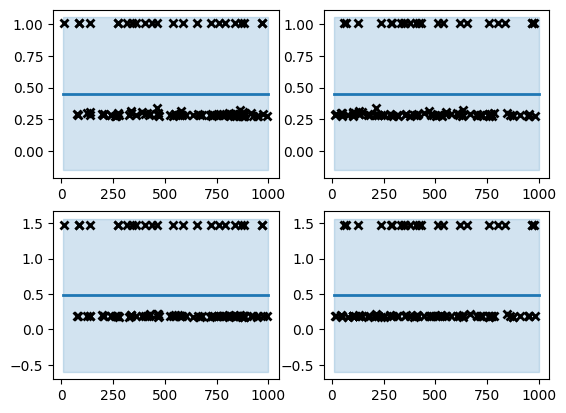

In [5]:
savename = "MOONNHouses"

### GPs Initialization
GP = GaussianProcess(O, C, d, lowerBounds, upperBounds, noise_variance=2e-6)

#### Initial samples, at least 1
for l in range(initial_iter):
    ## Get random evaluation point
    while True:
        x_rand = np.random.uniform(lowerBounds[0], upperBounds[0], d)
        if GP.X is None or not x_rand in GP.X:
            break
    ## EVALUATION OF THE OUTSIDE FUNCTION
    
    y_rand = evaluation(x_rand)
    GP.X = np.array([x_rand], dtype=float)
    GP.Y = np.array([y_rand], dtype=float)    
    
GP.updateGP()
GP.optimizeKernel()

if False:
    GP.plotSamples()

for l in range(total_iter):

    ## For all acq functions but usemo
    # x_best, acq_best = mesmo_acq(GP)
    ## For usemo
    x_best, acq_best = usemo_acq(GP, function = "ei", showplots = False)
    print("x_best = ", x_best)
    print("acq_best = ", acq_best)
    ## EVALUATION OF THE OUTSIDE FUNCTION
    y_best = evaluation(x_best)

    ## UPDATE
    GP.addSample(x_best,y_best)     ## Add new sample to the model
    GP.updateGP()                   ## Update data on the GP regressor
    GP.optimizeKernel()             ## Optimize kernel hyperparameters

    print("Iteration=", l, " x_best=", x_best, "y=", y_best)
    GP.plot()
    

## Evaluate results

As you are doing a real world experiment you do not have access to the real pareto front, then you do not have your metrics as before (I removed them).

What you should evaluate is the results in terms of the best *y* possible. You have the data below, but you may do a pandas dataframe to store it cleaner when it is computed in the previous section.

GP.X === samples where the function was evaluated

GP.Y === results of those evaluations

In [6]:
GP.X, GP.Y

(array([[422.85178466, 723.12124851],
        [882.31000638, 758.12997708],
        [882.40252974, 758.10290171],
        [583.75289828, 715.9820458 ],
        [468.24381226, 847.59974767],
        [882.32457839, 758.13473882],
        [882.28171274, 758.13091664],
        [882.32324394, 758.13804712],
        [237.50433762, 354.837576  ],
        [727.84510277, 531.26490037],
        [ 77.00293102, 480.36392403],
        [791.41773369, 910.76259379],
        [807.53568593, 411.26462997],
        [125.37282244, 446.16200916],
        [832.63111863, 626.02102346],
        [137.92369217, 614.87849028],
        [207.50069467,  18.54584315],
        [523.49685563, 406.58633988],
        [548.62907984, 357.68880984],
        [264.72027687, 294.44478766],
        [779.40254482, 249.23772042],
        [948.32011769, 772.29159333],
        [ 14.41792466, 799.88060796],
        [274.99522092, 347.12388854],
        [831.90919909, 132.96924844],
        [537.68109902, 980.33431818],
        [317

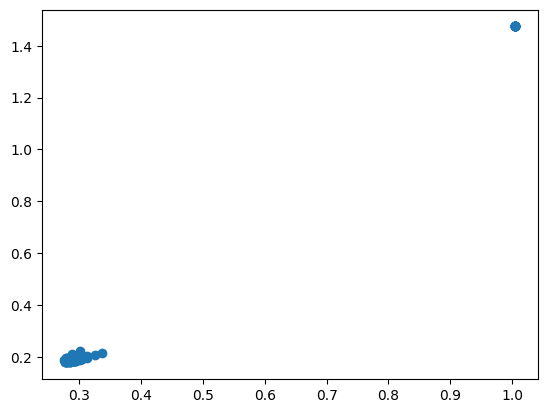

In [11]:
plt.scatter(GP.Y[:,0],GP.Y[:,1])

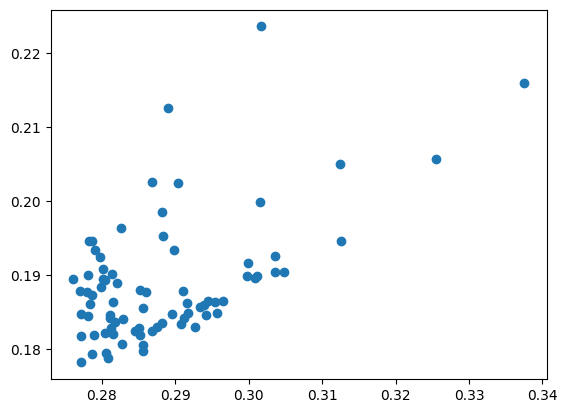

In [13]:
results = np.array([x for x in GP.Y if x[0]< 0.9])

plt.scatter(results[:,0],results[:,1])

In [14]:
results

array([[0.28448966, 0.18247981],
       [0.27874076, 0.17936616],
       [0.2881465 , 0.18359636],
       [0.28185472, 0.1836963 ],
       [0.30170548, 0.22357175],
       [0.27896214, 0.18193898],
       [0.29420078, 0.1846222 ],
       [0.28520462, 0.18801554],
       [0.2790699 , 0.19338855],
       [0.29391813, 0.18594335],
       [0.28050989, 0.18222637],
       [0.28263655, 0.19635195],
       [0.30107579, 0.18990044],
       [0.27818879, 0.1900468 ],
       [0.2804929 , 0.18937102],
       [0.28990674, 0.19342704],
       [0.28603613, 0.18776092],
       [0.29042006, 0.20238601],
       [0.27713951, 0.18472667],
       [0.27992988, 0.18841784],
       [0.27796018, 0.18773131],
       [0.29179606, 0.1849182 ],
       [0.27703053, 0.18785073],
       [0.29266664, 0.18300755],
       [0.27975658, 0.19247025],
       [0.2801111 , 0.18952222],
       [0.28819463, 0.19859222],
       [0.28158963, 0.18638705],
       [0.27711907, 0.17823316],
       [0.27867085, 0.19456251],
       [0.

In [10]:
evs = [row[0] for row in results if row[1][0] < 500000]
mae = [row[1][0] for row in GP.Y if row[1][0] < 500000]
mse = [row[1][1] for row in results if row[1][0] < 500000]
plt.scatter(mae, mse)

IndexError: invalid index to scalar variable.

In [ ]:
plt.scatter(evs, mae)

In [ ]:
mae

In [ ]:
results

In [ ]:
MOOnnHousesRegression(0)